# Self-supervised Vision Transformer for Land Cover Segmentation
### Pre-trained model with Swin Transformer and Sentinel-1/2, segmentation head trained with Flair1


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/BertilleT/LandCover_map_Transformers_SSL.git

Cloning into 'LandCover_map_Transformers_SSL'...
remote: Enumerating objects: 8729, done.
remote: Counting objects: 100% (312/312), done.
remote: Compressing objects: 100% (215/215), done.
remote: Total 8729 (delta 129), reused 269 (delta 87), pack-reused 8417
Receiving objects: 100% (8729/8729), 429.81 MiB | 19.73 MiB/s, done.
Resolving deltas: 100% (564/564), done.


In [3]:
cd LandCover_map_Transformers_SSL/src

/content/LandCover_map_Transformers_SSL/src


## Content

1. [Installation](#installation)
1. [Dataset](#dataset)
1. [Quick Start](#quickstart)

In [4]:
!pip install wandb
!pip install rasterio
!pip install timm
!pip install einops
!pip install diffdist
!pip install GPUtil

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 56.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for diffdist: filename=diffdist-0.1-py3-none-any.whl size=6534 sha256=ecd84bb4a4af0aee4c8c7264998a846b4ac07f069464dd698bded27a12a3527c
  Stored in directory: /root/.cache/pip/wheels/f1/29/f6/5331a14ab74e769799b76eb32460f447c7feb7375a16b07854
Successfully built diffdist
  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl s

In [5]:
# Import needed packages
import json
import random
import numpy as np
import torch
from tqdm import tqdm
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import psutil
import GPUtil
sys.path.append('../..')
from tools.utils_Flair1 import *
from tools.metrics import PixelwiseMetrics
from Transformer_SSL.models import build_model
from Transformer_SSL.models.swin_transformer import SwinTransformerDecoder
import csv

### Quick Start
You can specify in the some hyperparameters in train_config (cell below), such as the learning_rate, the batch_size, number of epochs, or if you wish to fine-tune the model or not (with the finetuning argument), etc.

In [6]:
# Data configurations:
data_config = {
    'train_dir': '../../drive/MyDrive/MVA/flair1_fullset_13classes/train', # path to the training directory,
    'val_dir': '../../drive/MyDrive/MVA/flair1_fullset_13classes/val', # path to the validation directory,
    'test_dir': '../../drive/MyDrive/MVA/flair1_fullset_13classes/test', # path to the validation directory,
    'train_mode': 'validation', # can be one of the following: 'test', 'validation'
    'val_mode': 'test', # can be one of the following: 'test', 'validation'
    'num_classes': 13, # number of classes in the dataset.
    'clip_sample_values': True, # clip (limit) values
    'train_used_data_fraction': 1, # fraction of data to use, should be in the range [0, 1]
    'val_used_data_fraction': 1,
    'image_px_size': 224, # image size (224x224)
    'cover_all_parts_train': True, # if True, if image_px_size is not 224 during training, we use a random crop of the image
    'cover_all_parts_validation': True, # if True, if image_px_size is not 224 during validation, we use a non-overlapping sliding window to cover the entire image
    'seed': 42,
}

In [7]:
# Ensure deterministic behavior
random.seed(data_config['seed'])
np.random.seed(data_config['seed'])
torch.manual_seed(data_config['seed'])
torch.cuda.manual_seed_all(data_config['seed'])

#### Prepare

We create the `train_dataset` and `val_dataset` by using the `DFCDataset`, a custom class of `torch.utils.data.Dataset`

In [8]:
#from dfc_dataset import DFCDataset
size = 224
multimodal = True
train_dataset = Flair1Dataset_SSL(data_config['train_dir'], size, multimodal)
val_dataset = Flair1Dataset_SSL(data_config['val_dir'], size, multimodal)
test_dataset = Flair1Dataset_SSL(data_config['test_dir'], size, multimodal)

We can see how many examples are in each split by checking their length:

In [9]:
len(train_dataset), len(val_dataset)

(1664, 416)

In [9]:
#loop on train_ds and check shape of rgb and ir_el
rgb = train_dataset[0][0]['rgb']
ir_el = train_dataset[0][0]['ir_el']
print(rgb.shape)
print(ir_el.shape)

torch.Size([3, 224, 224])
torch.Size([2, 224, 224])


We define a correspondance of label and names:

In [10]:
dict_classes_13 = {
1   : 'building',
2   : 'pervious surface',
3   : 'impervious surface',
4   : 'bare soil',
5   : 'water',
6   : 'coniferous',
7   : 'deciduous',
8   : 'brushwood',
9   : 'vineyard',
10  : 'herbaceous vegetation',
11  : 'agricultural land',
12  : 'plowed land',
13  : 'other'}

Our data is now ready to be used by the model. In the next section we load and configure the model.

<a id='quickstart'></a>
## 3. Quick Start

#### Configure

You can specify in the some hyperparameters in `train_config` (cell below), such as the `learning_rate`, the `batch_size`, number of `epochs`, or if you wish to fine-tune the model or not (with the `finetuning` argument), etc.

In [11]:
# Training configurations
train_config = {
    's1_input_channels': 2,
    's2_input_channels': 13,
    'finetuning': False, # If false, backbone layers is frozen and only the head is trained
    'classifier_lr': 3e-6,
    'learning_rate': 0.00001,
    'adam_betas': (0.9, 0.999),
    'weight_decay': 0.001,
    'dataloader_workers': 4,
    'batch_size': 16,
    'epochs': 60,
    'target': 'dfc_label'
}

#### Download checkpoint

You can download the pre-trained backbone model using this [link](https://drive.google.com/file/d/1e7QhC2-zoBFgb65yN1ADWBZLMShHOweY/view), save it in the `checkpoints/` directory then run the following cell.

Make sure to properly modify the path to the downloaded checkpoint in the path below.

In the case where you are using a uni-modal dataset (Sentinel-2 only or Sentinel-1 only), you can load the corresponding weight stream `s1_weights` or `s2_weights`, and comment the other one.

In [12]:
# path to the checkpoint
checkpoint = torch.load(
    "../../drive/MyDrive/MVA/swin_t.pth",#, map_location=torch.device('cpu') #comment map_location if using GPU
)
weights = checkpoint["state_dict"]

# Sentinel-1 stream weights
s1_weights = {
    k[len("backbone1."):]: v for k, v in weights.items() if "backbone1" in k
}

# Sentinel-2 stream weights
s2_weights = {
    k[len("backbone2."):]: v for k, v in weights.items() if "backbone2" in k
}

#### Prepare model and load checkpoint

We prepare the model by specifying the `input_channels`: only sentinel1, only sentinel2 or both. We also specify if we need both backbones `s1_backbone` and `s2_backbone` depending on our application. In the case where only one stream is needed, just comment the lines `s1_backbone` or `s2_backbone`.

In [13]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""

    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

def dotdictify(d):
    """recursively wrap a dictionary and
    all the dictionaries that it contains
    with the dotdict class
    """
    d = dotdict(d)
    for k, v in d.items():
        if isinstance(v, dict):
            d[k] = dotdictify(v)
    return d

In [14]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu:0")

with open("configs/backbone_config.json", "r") as fp:
    swin_conf = dotdictify(json.load(fp))

s1_backbone = build_model(swin_conf.model_config)

swin_conf.model_config.MODEL.SWIN.IN_CHANS = 13
s2_backbone = build_model(swin_conf.model_config)

s1_backbone.load_state_dict(s1_weights)
s2_backbone.load_state_dict(s2_weights)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<All keys matched successfully>

We create the downstream model head that will be trained. In this demo, we will train a classifier. You can find a segmentation head in the repository (/TransformerSSL/models/swin_transformer/DoubleSwinTransformerSegmentation). Our classifier takes as input the pre-trained backbone (in the form of two streams `encoder1` and `encoder2`), the `out_dim` (number of classes), and `freeze_layers` flag, specifying whether you wish to freeze the backbone weights or not.

In [15]:
class DoubleSwinTransformerSegmentation(nn.Module):
    def __init__(self, encoder1, encoder2, out_dim, device, freeze_layers=False):
        super(DoubleSwinTransformerSegmentation, self).__init__()

        self.device = device

        self.backbone1 = encoder1
        self.backbone2 = encoder2

        self.decoder1 = SwinTransformerDecoder(self.backbone1, out_dim, device)
        self.decoder2 = SwinTransformerDecoder(self.backbone2, out_dim, device)

        # freeze all backbone layers
        if freeze_layers:
            for name, param in self.named_parameters():
                if name.startswith(('backbone')):
                    param.requires_grad = False

        self.expand_channels = torch.nn.Conv2d(3, 13, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        expanded_rgb = self.expand_channels(x["rgb"].to(self.device))
        _, x2, x_seg2 = self.backbone2.forward_features(expanded_rgb)

        _, x1, x_seg1 = self.backbone1.forward_features(x["ir_el"].to(self.device))

        x1 = self.decoder1.forward_up_features(x1, x_seg1)
        x2 = self.decoder2.forward_up_features(x2, x_seg2)

        x = torch.cat([x1, x2], dim=-1)

        output = self.decoder1.up_x4(x)

        return output

In [16]:
model = DoubleSwinTransformerSegmentation(
        s1_backbone, s2_backbone, out_dim=data_config['num_classes'], device=device
    )

model = model.to(device)

Define and initialise the loss for training. Here we are training for single-class classification and using a `torch.nn.CrossEntropyLoss` loss.

In [17]:
criterion = torch.nn.CrossEntropyLoss(ignore_index=255, reduction="mean").to(device)

Define the trainable parameters (needed for the optimizer):

In [18]:
if train_config['finetuning']:
    # train all parameters (backbone + classifier head)
    param_backbone = []
    param_head = []
    for p in model.parameters():
        if p.requires_grad:
            param_head.append(p)
        else:
            param_backbone.append(p)
        p.requires_grad = True
    # parameters = model.parameters()
    parameters = [
        {"params": param_backbone},  # train with default lr
        {
            "params": param_head,
            "lr": train_config['classifier_lr'],
        },  # train with classifier lr
    ]
    print("Finetuning")

else:
    # train only final linear layer for SSL methods
    print("Frozen backbone")
    parameters = list(filter(lambda p: p.requires_grad, model.parameters()))

Frozen backbone


Initialise the selected optimizer. In this work we chose Adam optimizer. You can initialise any optimizer you want.

In [19]:
optimizer = torch.optim.Adam(
    parameters,
    lr=train_config['learning_rate'],
    betas=train_config['adam_betas'],
    weight_decay=train_config['weight_decay'],
)

We load the data (training and validation) using pytorch's dataloader

In [20]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=train_config['batch_size'],
    shuffle=True,
    pin_memory=True,
    num_workers=train_config['dataloader_workers'],
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=train_config['batch_size'],
    shuffle=False,
    num_workers=train_config['dataloader_workers'],
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=train_config['batch_size'],
    shuffle=False,
    num_workers=train_config['dataloader_workers'],
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Everything is set and we are now ready to train the segmentation head:

  0%|          | 0/104 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch:0, Training Loss:2.271: 100%|██████████| 104/104 [10:22<00:00,  5.98s/it]


{'train_loss': 2.2857770919799805, 'train_average_accuracy': 0.09757708621528634, 'train_mIoU': 0.051961727165734245, 'train_accuracy_pixelclass_0': 0.010105386278941026, 'train_accuracy_pixelclass_1': 0.013675079444485438, 'train_accuracy_pixelclass_2': 0.03513907093094926, 'train_accuracy_pixelclass_3': 0.008048923818072623, 'train_accuracy_pixelclass_4': 0.014842444605740008, 'train_accuracy_pixelclass_5': 0.021925479651456643, 'train_accuracy_pixelclass_6': 0.2824990281408804, 'train_accuracy_pixelclass_7': 0.03097990556143217, 'train_accuracy_pixelclass_8': 0.04722404274383261, 'train_accuracy_pixelclass_9': 0.747034488737236, 'train_accuracy_pixelclass_10': 0.03470004896422706, 'train_accuracy_pixelclass_11': 0.0028283376679886867, 'train_accuracy_pixelclass_12': 0.01949988425348034, 'train_IoU_class_0': 0.00873090598248244, 'train_IoU_class_1': 0.010931727569746943, 'train_IoU_class_2': 0.026739570858732745, 'train_IoU_class_3': 0.003888811928019539, 'train_IoU_class_4': 0.01065

Validation Loss:2.057: 100%|██████████| 26/26 [00:49<00:00,  1.91s/it]


Epoch:0 {'validation_loss': 2.0570242404937744, 'validation_average_accuracy': 0.1196552935359986, 'validation_mIoU': 0.059062951078334654, 'validation_accuracy_pixelclass_0': 0.00024438593993155177, 'validation_accuracy_pixelclass_1': 0.0005967899625224051, 'validation_accuracy_pixelclass_2': 0.0024325827078120654, 'validation_accuracy_pixelclass_3': 8.344354835345018e-06, 'validation_accuracy_pixelclass_4': 0.006989739371541334, 'validation_accuracy_pixelclass_5': 0.005439903804464074, 'validation_accuracy_pixelclass_6': 0.5984837267715295, 'validation_accuracy_pixelclass_7': 0.003751539276611587, 'validation_accuracy_pixelclass_8': 0.002227598532681609, 'validation_accuracy_pixelclass_9': 0.9284512886761594, 'validation_accuracy_pixelclass_10': 0.00688852322493178, 'validation_accuracy_pixelclass_11': 4.393344961052997e-06, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.00024365024309649255, 'train_IoU_class_1': 0.0005810857577467359, 'train_IoU_class_2': 0.0023292

Epoch:1, Training Loss:1.966: 100%|██████████| 104/104 [07:59<00:00,  4.61s/it]


{'train_loss': 1.9710967540740967, 'train_average_accuracy': 0.13061658942802365, 'train_mIoU': 0.0641904163552531, 'train_accuracy_pixelclass_0': 0.006631003609834687, 'train_accuracy_pixelclass_1': 0.0003741218685063173, 'train_accuracy_pixelclass_2': 0.005992764806759189, 'train_accuracy_pixelclass_3': 1.5498569611179635e-05, 'train_accuracy_pixelclass_4': 0.015535817532502452, 'train_accuracy_pixelclass_5': 0.0005527789511990355, 'train_accuracy_pixelclass_6': 0.7323418820299148, 'train_accuracy_pixelclass_7': 0.0021930993273741755, 'train_accuracy_pixelclass_8': 0.003106256003044085, 'train_accuracy_pixelclass_9': 0.9206015642472708, 'train_accuracy_pixelclass_10': 0.010665338537088379, 'train_accuracy_pixelclass_11': 9.98001999996008e-07, 'train_accuracy_pixelclass_12': 4.539079202393002e-06, 'train_IoU_class_0': 0.006587001348838404, 'train_IoU_class_1': 0.00037253127813504283, 'train_IoU_class_2': 0.005712490057339206, 'train_IoU_class_3': 1.5292312554478862e-05, 'train_IoU_cla

Validation Loss:1.856: 100%|██████████| 26/26 [00:30<00:00,  1.18s/it]


Epoch:1 {'validation_loss': 1.8556005954742432, 'validation_average_accuracy': 0.13806462706438472, 'validation_mIoU': 0.06978603342535399, 'validation_accuracy_pixelclass_0': 0.0173140369426713, 'validation_accuracy_pixelclass_1': 0.000784177937102819, 'validation_accuracy_pixelclass_2': 0.009371471691261993, 'validation_accuracy_pixelclass_3': 4.172177417672509e-06, 'validation_accuracy_pixelclass_4': 0.04552341305240502, 'validation_accuracy_pixelclass_5': 0.0, 'validation_accuracy_pixelclass_6': 0.8144598442369273, 'validation_accuracy_pixelclass_7': 0.004112525076831947, 'validation_accuracy_pixelclass_8': 0.00987965456097721, 'validation_accuracy_pixelclass_9': 0.8884277546248542, 'validation_accuracy_pixelclass_10': 0.004963101536551934, 'validation_accuracy_pixelclass_11': 0.0, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.017024517489725215, 'train_IoU_class_1': 0.0007811168550815202, 'train_IoU_class_2': 0.008676243612426976, 'train_IoU_class_3': 4.13842193

Epoch:2, Training Loss:1.811: 100%|██████████| 104/104 [08:24<00:00,  4.85s/it]


{'train_loss': 1.8160898685455322, 'train_average_accuracy': 0.14467271254621664, 'train_mIoU': 0.07545371094606361, 'train_accuracy_pixelclass_0': 0.051999491990919335, 'train_accuracy_pixelclass_1': 0.0009784031494833485, 'train_accuracy_pixelclass_2': 0.011890395093425293, 'train_accuracy_pixelclass_3': 5.166189870393212e-06, 'train_accuracy_pixelclass_4': 0.0651554170436093, 'train_accuracy_pixelclass_5': 7.4484170517675624e-06, 'train_accuracy_pixelclass_6': 0.8145724081967249, 'train_accuracy_pixelclass_7': 0.0041218855055729165, 'train_accuracy_pixelclass_8': 0.014420545960759052, 'train_accuracy_pixelclass_9': 0.9070214401141505, 'train_accuracy_pixelclass_10': 0.010572661439249384, 'train_accuracy_pixelclass_11': 0.0, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.05022213813987593, 'train_IoU_class_1': 0.0009719758906939585, 'train_IoU_class_2': 0.011059083800117251, 'train_IoU_class_3': 5.121481542180522e-06, 'train_IoU_class_4': 0.06341157349942646, 'train_IoU_

Validation Loss:1.756: 100%|██████████| 26/26 [00:29<00:00,  1.13s/it]


Epoch:2 {'validation_loss': 1.7561147212982178, 'validation_average_accuracy': 0.14634952462349968, 'validation_mIoU': 0.08283532137672599, 'validation_accuracy_pixelclass_0': 0.0911620147500043, 'validation_accuracy_pixelclass_1': 0.0010489652924881865, 'validation_accuracy_pixelclass_2': 0.013896217369349742, 'validation_accuracy_pixelclass_3': 0.00012099314511250277, 'validation_accuracy_pixelclass_4': 0.07765561824437828, 'validation_accuracy_pixelclass_5': 1.926993908772254e-06, 'validation_accuracy_pixelclass_6': 0.7442048200112202, 'validation_accuracy_pixelclass_7': 0.0008041165946453522, 'validation_accuracy_pixelclass_8': 0.010397414367336216, 'validation_accuracy_pixelclass_9': 0.9341783331778778, 'validation_accuracy_pixelclass_10': 0.029073400159174423, 'validation_accuracy_pixelclass_11': 0.0, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.08527408582953118, 'train_IoU_class_1': 0.0010441312726439634, 'train_IoU_class_2': 0.01279201603408767, 'train_IoU_

Epoch:3, Training Loss:1.712: 100%|██████████| 104/104 [08:03<00:00,  4.65s/it]


{'train_loss': 1.7144242525100708, 'train_average_accuracy': 0.16748247208317973, 'train_mIoU': 0.0982517887599229, 'train_accuracy_pixelclass_0': 0.19343418747481078, 'train_accuracy_pixelclass_1': 0.0017952434172715684, 'train_accuracy_pixelclass_2': 0.019652377990273796, 'train_accuracy_pixelclass_3': 0.00039521352508508067, 'train_accuracy_pixelclass_4': 0.17571801009925192, 'train_accuracy_pixelclass_5': 3.9902234205897655e-05, 'train_accuracy_pixelclass_6': 0.8246065259896012, 'train_accuracy_pixelclass_7': 0.00981762751584219, 'train_accuracy_pixelclass_8': 0.021428186970591595, 'train_accuracy_pixelclass_9': 0.9006466181047467, 'train_accuracy_pixelclass_10': 0.029738243759655593, 'train_accuracy_pixelclass_11': 0.0, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.17746496607604548, 'train_IoU_class_1': 0.0017687546686586276, 'train_IoU_class_2': 0.018051533047795814, 'train_IoU_class_3': 0.0003942587677480867, 'train_IoU_class_4': 0.164542640629693, 'train_IoU_clas

Validation Loss:1.655: 100%|██████████| 26/26 [00:34<00:00,  1.33s/it]


Epoch:3 {'validation_loss': 1.6545878648757935, 'validation_average_accuracy': 0.18577455909256718, 'validation_mIoU': 0.11549338806493573, 'validation_accuracy_pixelclass_0': 0.32077068418974447, 'validation_accuracy_pixelclass_1': 0.004252892292651133, 'validation_accuracy_pixelclass_2': 0.04322905142040136, 'validation_accuracy_pixelclass_3': 1.6688709670690035e-05, 'validation_accuracy_pixelclass_4': 0.2444130356708412, 'validation_accuracy_pixelclass_5': 0.0011099484914528185, 'validation_accuracy_pixelclass_6': 0.8149902304749198, 'validation_accuracy_pixelclass_7': 0.018896363162265756, 'validation_accuracy_pixelclass_8': 0.026548823049282758, 'validation_accuracy_pixelclass_9': 0.8943281295715715, 'validation_accuracy_pixelclass_10': 0.046513421170572264, 'validation_accuracy_pixelclass_11': 0.0, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.26315445004490307, 'train_IoU_class_1': 0.00417071570320404, 'train_IoU_class_2': 0.03853311923937643, 'train_IoU_class

Epoch:4, Training Loss:1.635: 100%|██████████| 104/104 [08:40<00:00,  5.00s/it]


{'train_loss': 1.6335484981536865, 'train_average_accuracy': 0.2013522564900539, 'train_mIoU': 0.1283077076594633, 'train_accuracy_pixelclass_0': 0.3689887085763916, 'train_accuracy_pixelclass_1': 0.003445170499610647, 'train_accuracy_pixelclass_2': 0.04427849281834951, 'train_accuracy_pixelclass_3': 0.0009505789361523509, 'train_accuracy_pixelclass_4': 0.3584578927890807, 'train_accuracy_pixelclass_5': 0.0025149048145503765, 'train_accuracy_pixelclass_6': 0.8371665474846393, 'train_accuracy_pixelclass_7': 0.01000711474294963, 'train_accuracy_pixelclass_8': 0.0573680179398373, 'train_accuracy_pixelclass_9': 0.8679599262217403, 'train_accuracy_pixelclass_10': 0.06643744046819682, 'train_accuracy_pixelclass_11': 0.0, 'train_accuracy_pixelclass_12': 4.539079202393002e-06, 'train_IoU_class_0': 0.29991213235340025, 'train_IoU_class_1': 0.0033653454063740543, 'train_IoU_class_2': 0.03944981567363908, 'train_IoU_class_3': 0.0009503371372643202, 'train_IoU_class_4': 0.32124706804976294, 'train

Validation Loss:1.567: 100%|██████████| 26/26 [00:33<00:00,  1.29s/it]


Epoch:4 {'validation_loss': 1.567387342453003, 'validation_average_accuracy': 0.19950856518871088, 'validation_mIoU': 0.13230949504887873, 'validation_accuracy_pixelclass_0': 0.31759669654840206, 'validation_accuracy_pixelclass_1': 0.004158179892455597, 'validation_accuracy_pixelclass_2': 0.03510625823863046, 'validation_accuracy_pixelclass_3': 0.00026701935473104056, 'validation_accuracy_pixelclass_4': 0.43083697945428545, 'validation_accuracy_pixelclass_5': 0.011297965287131728, 'validation_accuracy_pixelclass_6': 0.787116855137943, 'validation_accuracy_pixelclass_7': 0.02487109264900273, 'validation_accuracy_pixelclass_8': 0.015296489318785241, 'validation_accuracy_pixelclass_9': 0.9337857951674682, 'validation_accuracy_pixelclass_10': 0.03327801640440585, 'validation_accuracy_pixelclass_11': 0.0, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.2670885785696269, 'train_IoU_class_1': 0.004067073340797437, 'train_IoU_class_2': 0.03180867926144883, 'train_IoU_class_3':

Epoch:5, Training Loss:1.551: 100%|██████████| 104/104 [08:17<00:00,  4.78s/it]


{'train_loss': 1.5533599853515625, 'train_average_accuracy': 0.23696860099306447, 'train_mIoU': 0.15879650287895114, 'train_accuracy_pixelclass_0': 0.4829230596690464, 'train_accuracy_pixelclass_1': 0.008283933677083185, 'train_accuracy_pixelclass_2': 0.11481316657025027, 'train_accuracy_pixelclass_3': 0.003953426798318405, 'train_accuracy_pixelclass_4': 0.5294661219388095, 'train_accuracy_pixelclass_5': 0.02051666476909375, 'train_accuracy_pixelclass_6': 0.8416813171223231, 'train_accuracy_pixelclass_7': 0.029462033919290285, 'train_accuracy_pixelclass_8': 0.1026657617307073, 'train_accuracy_pixelclass_9': 0.8454888712396301, 'train_accuracy_pixelclass_10': 0.10093407721320279, 'train_accuracy_pixelclass_11': 0.00024451048999902196, 'train_accuracy_pixelclass_12': 0.0001588677720837551, 'train_IoU_class_0': 0.37121632162365953, 'train_IoU_class_1': 0.00797138188786173, 'train_IoU_class_2': 0.0966713276680663, 'train_IoU_class_3': 0.003946301422138222, 'train_IoU_class_4': 0.4513517318

Validation Loss:1.538: 100%|██████████| 26/26 [00:32<00:00,  1.25s/it]


Epoch:5 {'validation_loss': 1.5377275943756104, 'validation_average_accuracy': 0.1981620413271562, 'validation_mIoU': 0.133854072436598, 'validation_accuracy_pixelclass_0': 0.34274926103548947, 'validation_accuracy_pixelclass_1': 0.0022517109336809516, 'validation_accuracy_pixelclass_2': 0.025555120574779815, 'validation_accuracy_pixelclass_3': 0.0, 'validation_accuracy_pixelclass_4': 0.3182107811902638, 'validation_accuracy_pixelclass_5': 0.023343604210867088, 'validation_accuracy_pixelclass_6': 0.7498796370516461, 'validation_accuracy_pixelclass_7': 0.013550155924764228, 'validation_accuracy_pixelclass_8': 0.09768773044122751, 'validation_accuracy_pixelclass_9': 0.9294470652466837, 'validation_accuracy_pixelclass_10': 0.07343147064362827, 'validation_accuracy_pixelclass_11': 0.0, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.28563409535415285, 'train_IoU_class_1': 0.002223844928305895, 'train_IoU_class_2': 0.023892332881861808, 'train_IoU_class_3': 0.0, 'train_IoU_

Epoch:6, Training Loss:1.495: 100%|██████████| 104/104 [07:57<00:00,  4.59s/it]


{'train_loss': 1.4960676431655884, 'train_average_accuracy': 0.2577535759380574, 'train_mIoU': 0.17573397632878815, 'train_accuracy_pixelclass_0': 0.5589354546809299, 'train_accuracy_pixelclass_1': 0.011992884915103896, 'train_accuracy_pixelclass_2': 0.23363310567705783, 'train_accuracy_pixelclass_3': 0.0033102361594544503, 'train_accuracy_pixelclass_4': 0.5902570125650375, 'train_accuracy_pixelclass_5': 0.022495283555916862, 'train_accuracy_pixelclass_6': 0.8337197660503866, 'train_accuracy_pixelclass_7': 0.04735188908537422, 'train_accuracy_pixelclass_8': 0.09125562454828758, 'train_accuracy_pixelclass_9': 0.8295276146310799, 'train_accuracy_pixelclass_10': 0.12827122653209358, 'train_accuracy_pixelclass_11': 9.98001999996008e-07, 'train_accuracy_pixelclass_12': 4.5390792023930026e-05, 'train_IoU_class_0': 0.4185355196956482, 'train_IoU_class_1': 0.011507066532664013, 'train_IoU_class_2': 0.18288220189475296, 'train_IoU_class_3': 0.003281206992568316, 'train_IoU_class_4': 0.490097372

Validation Loss:1.433: 100%|██████████| 26/26 [00:31<00:00,  1.20s/it]


Epoch:6 {'validation_loss': 1.4327585697174072, 'validation_average_accuracy': 0.30448145096352824, 'validation_mIoU': 0.20549159374989434, 'validation_accuracy_pixelclass_0': 0.663424008595922, 'validation_accuracy_pixelclass_1': 0.04014787355385367, 'validation_accuracy_pixelclass_2': 0.5697070877280576, 'validation_accuracy_pixelclass_3': 0.0008260911286991568, 'validation_accuracy_pixelclass_4': 0.6332021630861951, 'validation_accuracy_pixelclass_5': 0.07124096480731025, 'validation_accuracy_pixelclass_6': 0.855988455259553, 'validation_accuracy_pixelclass_7': 0.07037489769556915, 'validation_accuracy_pixelclass_8': 0.20108840968580247, 'validation_accuracy_pixelclass_9': 0.7679883125757087, 'validation_accuracy_pixelclass_10': 0.08391473746735079, 'validation_accuracy_pixelclass_11': 0.0003558609418452927, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.41052824312231606, 'train_IoU_class_1': 0.03659941640725601, 'train_IoU_class_2': 0.33979429342331713, 'train_Io

Epoch:7, Training Loss:1.426: 100%|██████████| 104/104 [07:34<00:00,  4.37s/it]


{'train_loss': 1.4266126155853271, 'train_average_accuracy': 0.2981604254941478, 'train_mIoU': 0.2070796875850025, 'train_accuracy_pixelclass_0': 0.62918512168405, 'train_accuracy_pixelclass_1': 0.01722201650784539, 'train_accuracy_pixelclass_2': 0.45135295131774916, 'train_accuracy_pixelclass_3': 0.004070957617869851, 'train_accuracy_pixelclass_4': 0.6549344827816632, 'train_accuracy_pixelclass_5': 0.07492149900457226, 'train_accuracy_pixelclass_6': 0.8378584739774259, 'train_accuracy_pixelclass_7': 0.07827006774706685, 'train_accuracy_pixelclass_8': 0.2103742963647997, 'train_accuracy_pixelclass_9': 0.7921579549520568, 'train_accuracy_pixelclass_10': 0.1253164564844183, 'train_accuracy_pixelclass_11': 0.0004121748259983513, 'train_accuracy_pixelclass_12': 9.078158404786004e-06, 'train_IoU_class_0': 0.45235088458236195, 'train_IoU_class_1': 0.01636443046108701, 'train_IoU_class_2': 0.31724089980522946, 'train_IoU_class_3': 0.004013083262565394, 'train_IoU_class_4': 0.5261116591255394,

Validation Loss:1.363: 100%|██████████| 26/26 [00:28<00:00,  1.09s/it]


Epoch:7 {'validation_loss': 1.3633952140808105, 'validation_average_accuracy': 0.309488477105187, 'validation_mIoU': 0.22105570417814213, 'validation_accuracy_pixelclass_0': 0.5266234244933283, 'validation_accuracy_pixelclass_1': 0.027921826625386996, 'validation_accuracy_pixelclass_2': 0.5841328469113528, 'validation_accuracy_pixelclass_3': 0.001435229031679343, 'validation_accuracy_pixelclass_4': 0.7061889443691406, 'validation_accuracy_pixelclass_5': 0.12680198017894065, 'validation_accuracy_pixelclass_6': 0.8240232132376828, 'validation_accuracy_pixelclass_7': 0.1439700298887199, 'validation_accuracy_pixelclass_8': 0.14994452992335044, 'validation_accuracy_pixelclass_9': 0.8624237824561638, 'validation_accuracy_pixelclass_10': 0.0698843952516858, 'validation_accuracy_pixelclass_11': 0.0, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.3953016979987871, 'train_IoU_class_1': 0.026332774348956083, 'train_IoU_class_2': 0.4094711213722328, 'train_IoU_class_3': 0.0014350

Epoch:8, Training Loss:1.36: 100%|██████████| 104/104 [07:05<00:00,  4.09s/it]


{'train_loss': 1.359344720840454, 'train_average_accuracy': 0.3237636574714316, 'train_mIoU': 0.22930909933855076, 'train_accuracy_pixelclass_0': 0.6349406802098201, 'train_accuracy_pixelclass_1': 0.019478030043024015, 'train_accuracy_pixelclass_2': 0.6169474811301744, 'train_accuracy_pixelclass_3': 0.008786397422071254, 'train_accuracy_pixelclass_4': 0.6847103791785742, 'train_accuracy_pixelclass_5': 0.12977323826315684, 'train_accuracy_pixelclass_6': 0.8488792464832565, 'train_accuracy_pixelclass_7': 0.0974063038596359, 'train_accuracy_pixelclass_8': 0.2524741104557233, 'train_accuracy_pixelclass_9': 0.7942650103132992, 'train_accuracy_pixelclass_10': 0.12031158185587912, 'train_accuracy_pixelclass_11': 0.0009550879139961796, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.47325939486288454, 'train_IoU_class_1': 0.018401756076804696, 'train_IoU_class_2': 0.4146098095055503, 'train_IoU_class_3': 0.00878011509784866, 'train_IoU_class_4': 0.5544043773628075, 'train_IoU_class

Validation Loss:1.312: 100%|██████████| 26/26 [01:01<00:00,  2.38s/it]


Epoch:8 {'validation_loss': 1.3115222454071045, 'validation_average_accuracy': 0.3564520073359646, 'validation_mIoU': 0.2516018068699545, 'validation_accuracy_pixelclass_0': 0.6082675157563291, 'validation_accuracy_pixelclass_1': 0.015283322470262343, 'validation_accuracy_pixelclass_2': 0.7972923392320509, 'validation_accuracy_pixelclass_3': 0.005373764513962192, 'validation_accuracy_pixelclass_4': 0.7670859223044771, 'validation_accuracy_pixelclass_5': 0.2906696881931156, 'validation_accuracy_pixelclass_6': 0.828398583995027, 'validation_accuracy_pixelclass_7': 0.10798600068429041, 'validation_accuracy_pixelclass_8': 0.31208250851401176, 'validation_accuracy_pixelclass_9': 0.7940768991684696, 'validation_accuracy_pixelclass_10': 0.10735955053554296, 'validation_accuracy_pixelclass_11': 0.0, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.43322829809102464, 'train_IoU_class_1': 0.014869737453566132, 'train_IoU_class_2': 0.4753201917401552, 'train_IoU_class_3': 0.005371

Epoch:9, Training Loss:1.304: 100%|██████████| 104/104 [08:15<00:00,  4.76s/it]


{'train_loss': 1.3086700439453125, 'train_average_accuracy': 0.3456781883314796, 'train_mIoU': 0.2479402892173178, 'train_accuracy_pixelclass_0': 0.6674734895563678, 'train_accuracy_pixelclass_1': 0.025030287399155766, 'train_accuracy_pixelclass_2': 0.7336807321003631, 'train_accuracy_pixelclass_3': 0.017410059863225122, 'train_accuracy_pixelclass_4': 0.6857763724344963, 'train_accuracy_pixelclass_5': 0.24350418228617457, 'train_accuracy_pixelclass_6': 0.8540501795508667, 'train_accuracy_pixelclass_7': 0.12127397861270588, 'train_accuracy_pixelclass_8': 0.2445088606873541, 'train_accuracy_pixelclass_9': 0.7823609821267793, 'train_accuracy_pixelclass_10': 0.1185642086237233, 'train_accuracy_pixelclass_11': 0.0001377242759994491, 'train_accuracy_pixelclass_12': 4.5390792023930026e-05, 'train_IoU_class_0': 0.49647372827576647, 'train_IoU_class_1': 0.023802156735851357, 'train_IoU_class_2': 0.47860927439604534, 'train_IoU_class_3': 0.017391057538855725, 'train_IoU_class_4': 0.5517048852316

Validation Loss:1.279: 100%|██████████| 26/26 [00:31<00:00,  1.21s/it]


Epoch:9 {'validation_loss': 1.2786577939987183, 'validation_average_accuracy': 0.38191308873066315, 'validation_mIoU': 0.2728400170138563, 'validation_accuracy_pixelclass_0': 0.532018092638429, 'validation_accuracy_pixelclass_1': 0.04539168160338928, 'validation_accuracy_pixelclass_2': 0.757189002929501, 'validation_accuracy_pixelclass_3': 0.01088938306012525, 'validation_accuracy_pixelclass_4': 0.7375784093000863, 'validation_accuracy_pixelclass_5': 0.24393815891147969, 'validation_accuracy_pixelclass_6': 0.8500067718957173, 'validation_accuracy_pixelclass_7': 0.18217122031287444, 'validation_accuracy_pixelclass_8': 0.6366041523984651, 'validation_accuracy_pixelclass_9': 0.6574753425668887, 'validation_accuracy_pixelclass_10': 0.3071047592965855, 'validation_accuracy_pixelclass_11': 0.004503178585079322, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.42108056435653063, 'train_IoU_class_1': 0.04202971529443715, 'train_IoU_class_2': 0.5067676310601578, 'train_IoU_class

Epoch:10, Training Loss:1.267: 100%|██████████| 104/104 [07:14<00:00,  4.18s/it]


{'train_loss': 1.26869535446167, 'train_average_accuracy': 0.37368183346154776, 'train_mIoU': 0.27400186055537, 'train_accuracy_pixelclass_0': 0.6785795308187909, 'train_accuracy_pixelclass_1': 0.035978880391794504, 'train_accuracy_pixelclass_2': 0.7612534138679389, 'train_accuracy_pixelclass_3': 0.025880028155734792, 'train_accuracy_pixelclass_4': 0.6990443290908923, 'train_accuracy_pixelclass_5': 0.3261103195690133, 'train_accuracy_pixelclass_6': 0.8529255453613448, 'train_accuracy_pixelclass_7': 0.18193537157709538, 'train_accuracy_pixelclass_8': 0.3592787165337038, 'train_accuracy_pixelclass_9': 0.762162035759515, 'train_accuracy_pixelclass_10': 0.16268774377034512, 'train_accuracy_pixelclass_11': 0.012027920103951888, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5156897828293, 'train_IoU_class_1': 0.03407192011193765, 'train_IoU_class_2': 0.49702910388873345, 'train_IoU_class_3': 0.025844779130192525, 'train_IoU_class_4': 0.5751446289808805, 'train_IoU_class_5': 0.3

Validation Loss:1.253: 100%|██████████| 26/26 [00:29<00:00,  1.15s/it]


Epoch:10 {'validation_loss': 1.2525418996810913, 'validation_average_accuracy': 0.3355302801729414, 'validation_mIoU': 0.2485006230281104, 'validation_accuracy_pixelclass_0': 0.6420361994148875, 'validation_accuracy_pixelclass_1': 0.03542549291184618, 'validation_accuracy_pixelclass_2': 0.7336381035594666, 'validation_accuracy_pixelclass_3': 0.01707672217053358, 'validation_accuracy_pixelclass_4': 0.6270079410132934, 'validation_accuracy_pixelclass_5': 0.02424158337235496, 'validation_accuracy_pixelclass_6': 0.8257349716795849, 'validation_accuracy_pixelclass_7': 0.1960341301146563, 'validation_accuracy_pixelclass_8': 0.2517907570199552, 'validation_accuracy_pixelclass_9': 0.8412050066218003, 'validation_accuracy_pixelclass_10': 0.16769394767993698, 'validation_accuracy_pixelclass_11': 8.786689922105994e-06, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.4800426457585667, 'train_IoU_class_1': 0.0337799780918124, 'train_IoU_class_2': 0.527960985209875, 'train_IoU_class

Epoch:11, Training Loss:1.23: 100%|██████████| 104/104 [07:54<00:00,  4.56s/it]


{'train_loss': 1.2288892269134521, 'train_average_accuracy': 0.3857630635649167, 'train_mIoU': 0.2854544522379742, 'train_accuracy_pixelclass_0': 0.7245866152921999, 'train_accuracy_pixelclass_1': 0.04881432927372746, 'train_accuracy_pixelclass_2': 0.7764537566361949, 'train_accuracy_pixelclass_3': 0.029600976409885505, 'train_accuracy_pixelclass_4': 0.7259996391533277, 'train_accuracy_pixelclass_5': 0.3053686061989983, 'train_accuracy_pixelclass_6': 0.8609123757614023, 'train_accuracy_pixelclass_7': 0.22170095290901473, 'train_accuracy_pixelclass_8': 0.36446612376265697, 'train_accuracy_pixelclass_9': 0.7787519888489057, 'train_accuracy_pixelclass_10': 0.16804537254844168, 'train_accuracy_pixelclass_11': 0.010214550469959142, 'train_accuracy_pixelclass_12': 4.539079202393002e-06, 'train_IoU_class_0': 0.5424258926266118, 'train_IoU_class_1': 0.04549442599645434, 'train_IoU_class_2': 0.5161981181070562, 'train_IoU_class_3': 0.0295660362754457, 'train_IoU_class_4': 0.6079532403718814, 't

Validation Loss:1.21: 100%|██████████| 26/26 [00:32<00:00,  1.23s/it]


Epoch:11 {'validation_loss': 1.209908127784729, 'validation_average_accuracy': 0.40361480275545486, 'validation_mIoU': 0.3024645434646718, 'validation_accuracy_pixelclass_0': 0.6870981391323491, 'validation_accuracy_pixelclass_1': 0.07490936125142578, 'validation_accuracy_pixelclass_2': 0.7416984864560225, 'validation_accuracy_pixelclass_3': 0.009191306851132537, 'validation_accuracy_pixelclass_4': 0.7172013238025727, 'validation_accuracy_pixelclass_5': 0.35429517307295794, 'validation_accuracy_pixelclass_6': 0.8328610896343271, 'validation_accuracy_pixelclass_7': 0.17462292433164872, 'validation_accuracy_pixelclass_8': 0.6178287628179268, 'validation_accuracy_pixelclass_9': 0.725146525749977, 'validation_accuracy_pixelclass_10': 0.30086162620554996, 'validation_accuracy_pixelclass_11': 0.011277716515023043, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.4912176586824575, 'train_IoU_class_1': 0.06912043993508477, 'train_IoU_class_2': 0.5345846923270118, 'train_IoU_cla

Epoch:12, Training Loss:1.198: 100%|██████████| 104/104 [08:05<00:00,  4.67s/it]


{'train_loss': 1.1960173845291138, 'train_average_accuracy': 0.4076607298203765, 'train_mIoU': 0.30500540278859484, 'train_accuracy_pixelclass_0': 0.7193316403111351, 'train_accuracy_pixelclass_1': 0.06098028504115002, 'train_accuracy_pixelclass_2': 0.7875297103094699, 'train_accuracy_pixelclass_3': 0.0451292516128199, 'train_accuracy_pixelclass_4': 0.7226416012937021, 'train_accuracy_pixelclass_5': 0.4307829243975029, 'train_accuracy_pixelclass_6': 0.8607595161452052, 'train_accuracy_pixelclass_7': 0.2254424284510765, 'train_accuracy_pixelclass_8': 0.4355571328612354, 'train_accuracy_pixelclass_9': 0.7615008500125833, 'train_accuracy_pixelclass_10': 0.22961482650909554, 'train_accuracy_pixelclass_11': 0.020319320719918724, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5395101270446421, 'train_IoU_class_1': 0.05668298203826925, 'train_IoU_class_2': 0.5271213629134107, 'train_IoU_class_3': 0.04499900837855728, 'train_IoU_class_4': 0.6019191078266342, 'train_IoU_class_5': 0

Validation Loss:1.175: 100%|██████████| 26/26 [00:32<00:00,  1.24s/it]


Epoch:12 {'validation_loss': 1.1754239797592163, 'validation_average_accuracy': 0.4352965710875942, 'validation_mIoU': 0.32157752984149435, 'validation_accuracy_pixelclass_0': 0.7642685538916442, 'validation_accuracy_pixelclass_1': 0.1311491771223725, 'validation_accuracy_pixelclass_2': 0.8257339354980247, 'validation_accuracy_pixelclass_3': 0.01484877942949646, 'validation_accuracy_pixelclass_4': 0.770064606817506, 'validation_accuracy_pixelclass_5': 0.44201771678199725, 'validation_accuracy_pixelclass_6': 0.8702084891474452, 'validation_accuracy_pixelclass_7': 0.3471861948177813, 'validation_accuracy_pixelclass_8': 0.5851536040304347, 'validation_accuracy_pixelclass_9': 0.7353482605127726, 'validation_accuracy_pixelclass_10': 0.1700731520040976, 'validation_accuracy_pixelclass_11': 0.002802954085151812, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5374278690131103, 'train_IoU_class_1': 0.10778809993529935, 'train_IoU_class_2': 0.5479806267684695, 'train_IoU_class_

Epoch:13, Training Loss:1.181: 100%|██████████| 104/104 [07:46<00:00,  4.49s/it]


{'train_loss': 1.181461215019226, 'train_average_accuracy': 0.41958205648999514, 'train_mIoU': 0.31367128325476923, 'train_accuracy_pixelclass_0': 0.7329487929919328, 'train_accuracy_pixelclass_1': 0.08842972838255925, 'train_accuracy_pixelclass_2': 0.7808811799425667, 'train_accuracy_pixelclass_3': 0.029639722833913452, 'train_accuracy_pixelclass_4': 0.7451187850604386, 'train_accuracy_pixelclass_5': 0.4564953920899939, 'train_accuracy_pixelclass_6': 0.8544346113400529, 'train_accuracy_pixelclass_7': 0.2516221703644489, 'train_accuracy_pixelclass_8': 0.5376515530272612, 'train_accuracy_pixelclass_9': 0.7471721109338403, 'train_accuracy_pixelclass_10': 0.2027525824530393, 'train_accuracy_pixelclass_11': 0.02742010494989032, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5493227520091377, 'train_IoU_class_1': 0.07829059426096052, 'train_IoU_class_2': 0.5236887617033683, 'train_IoU_class_3': 0.02961214783234794, 'train_IoU_class_4': 0.626702537115182, 'train_IoU_class_5': 0.

Validation Loss:1.143: 100%|██████████| 26/26 [00:32<00:00,  1.27s/it]


Epoch:13 {'validation_loss': 1.1433894634246826, 'validation_average_accuracy': 0.4196012045607815, 'validation_mIoU': 0.3252004948901889, 'validation_accuracy_pixelclass_0': 0.6534991118287844, 'validation_accuracy_pixelclass_1': 0.11388911520286785, 'validation_accuracy_pixelclass_2': 0.7581927683500422, 'validation_accuracy_pixelclass_3': 0.01834089192808835, 'validation_accuracy_pixelclass_4': 0.7837853493518079, 'validation_accuracy_pixelclass_5': 0.4712559953597987, 'validation_accuracy_pixelclass_6': 0.8305864272267461, 'validation_accuracy_pixelclass_7': 0.339769783001563, 'validation_accuracy_pixelclass_8': 0.4768872726078676, 'validation_accuracy_pixelclass_9': 0.8051504511300811, 'validation_accuracy_pixelclass_10': 0.2021360964692346, 'validation_accuracy_pixelclass_11': 0.001322396833276952, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5213370521112282, 'train_IoU_class_1': 0.09861647687940536, 'train_IoU_class_2': 0.5469666401188342, 'train_IoU_class_3

Epoch:14, Training Loss:1.145: 100%|██████████| 104/104 [07:35<00:00,  4.38s/it]


{'train_loss': 1.144779920578003, 'train_average_accuracy': 0.43499859114526507, 'train_mIoU': 0.32841434338725745, 'train_accuracy_pixelclass_0': 0.7433939615541596, 'train_accuracy_pixelclass_1': 0.0897806738751692, 'train_accuracy_pixelclass_2': 0.7843496851508859, 'train_accuracy_pixelclass_3': 0.04954763549947369, 'train_accuracy_pixelclass_4': 0.7385662677094096, 'train_accuracy_pixelclass_5': 0.49973558119466227, 'train_accuracy_pixelclass_6': 0.8590206534647137, 'train_accuracy_pixelclass_7': 0.27621585394410664, 'train_accuracy_pixelclass_8': 0.5575189845144849, 'train_accuracy_pixelclass_9': 0.7409951816278375, 'train_accuracy_pixelclass_10': 0.271138732737723, 'train_accuracy_pixelclass_11': 0.044718473615821125, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5575567138344941, 'train_IoU_class_1': 0.0798840173741042, 'train_IoU_class_2': 0.5293144485349104, 'train_IoU_class_3': 0.049175893903230024, 'train_IoU_class_4': 0.6285531760820896, 'train_IoU_class_5': 0

Validation Loss:1.127: 100%|██████████| 26/26 [00:28<00:00,  1.10s/it]


Epoch:14 {'validation_loss': 1.1268445253372192, 'validation_average_accuracy': 0.4301077417894944, 'validation_mIoU': 0.3332088047775463, 'validation_accuracy_pixelclass_0': 0.760338181667621, 'validation_accuracy_pixelclass_1': 0.17294687958285807, 'validation_accuracy_pixelclass_2': 0.7338272256358757, 'validation_accuracy_pixelclass_3': 0.019146122169699145, 'validation_accuracy_pixelclass_4': 0.6975785637694647, 'validation_accuracy_pixelclass_5': 0.35524518106998265, 'validation_accuracy_pixelclass_6': 0.8625627189619078, 'validation_accuracy_pixelclass_7': 0.2850634777326776, 'validation_accuracy_pixelclass_8': 0.6245226993404572, 'validation_accuracy_pixelclass_9': 0.810000057726178, 'validation_accuracy_pixelclass_10': 0.19725758263307025, 'validation_accuracy_pixelclass_11': 0.07291195297363554, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5339478090421115, 'train_IoU_class_1': 0.1362464277633988, 'train_IoU_class_2': 0.5575512406384532, 'train_IoU_class_3

Epoch:15, Training Loss:1.102: 100%|██████████| 104/104 [06:54<00:00,  3.98s/it]


{'train_loss': 1.1025692224502563, 'train_average_accuracy': 0.45633271630281497, 'train_mIoU': 0.34956273387478193, 'train_accuracy_pixelclass_0': 0.7751744872923475, 'train_accuracy_pixelclass_1': 0.12852394932792324, 'train_accuracy_pixelclass_2': 0.791799167714941, 'train_accuracy_pixelclass_3': 0.06086546595803762, 'train_accuracy_pixelclass_4': 0.755633297047135, 'train_accuracy_pixelclass_5': 0.5365962010944917, 'train_accuracy_pixelclass_6': 0.8581570980886968, 'train_accuracy_pixelclass_7': 0.33583578491405336, 'train_accuracy_pixelclass_8': 0.6376322972334691, 'train_accuracy_pixelclass_9': 0.7631192823755342, 'train_accuracy_pixelclass_10': 0.23523689117217952, 'train_accuracy_pixelclass_11': 0.053751389717784995, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5833819902670716, 'train_IoU_class_1': 0.11078159058185032, 'train_IoU_class_2': 0.5501240310867761, 'train_IoU_class_3': 0.060790642116153135, 'train_IoU_class_4': 0.657138500629698, 'train_IoU_class_5': 

Validation Loss:1.102: 100%|██████████| 26/26 [00:30<00:00,  1.18s/it]


Epoch:15 {'validation_loss': 1.102468729019165, 'validation_average_accuracy': 0.4726411737102124, 'validation_mIoU': 0.3550326754606497, 'validation_accuracy_pixelclass_0': 0.7025469660293445, 'validation_accuracy_pixelclass_1': 0.1940585791103145, 'validation_accuracy_pixelclass_2': 0.7565138371167205, 'validation_accuracy_pixelclass_3': 0.01977194878235002, 'validation_accuracy_pixelclass_4': 0.7651344591576528, 'validation_accuracy_pixelclass_5': 0.49973696533145257, 'validation_accuracy_pixelclass_6': 0.8160734180835819, 'validation_accuracy_pixelclass_7': 0.47424942837634765, 'validation_accuracy_pixelclass_8': 0.8431469241666588, 'validation_accuracy_pixelclass_9': 0.6955768987127366, 'validation_accuracy_pixelclass_10': 0.3640294776452467, 'validation_accuracy_pixelclass_11': 0.013496355720354807, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.538534899707079, 'train_IoU_class_1': 0.15110927131310825, 'train_IoU_class_2': 0.5654300657290268, 'train_IoU_class_3

Epoch:16, Training Loss:1.09: 100%|██████████| 104/104 [07:15<00:00,  4.19s/it]


{'train_loss': 1.0880887508392334, 'train_average_accuracy': 0.46271588225025106, 'train_mIoU': 0.3538717908604572, 'train_accuracy_pixelclass_0': 0.775630517621309, 'train_accuracy_pixelclass_1': 0.1283062004720073, 'train_accuracy_pixelclass_2': 0.7923432330425381, 'train_accuracy_pixelclass_3': 0.06763575778318792, 'train_accuracy_pixelclass_4': 0.771282078044071, 'train_accuracy_pixelclass_5': 0.5348931737385839, 'train_accuracy_pixelclass_6': 0.8534039080319443, 'train_accuracy_pixelclass_7': 0.34442838468419246, 'train_accuracy_pixelclass_8': 0.6163219764446091, 'train_accuracy_pixelclass_9': 0.7431235203765674, 'train_accuracy_pixelclass_10': 0.32354363596851093, 'train_accuracy_pixelclass_11': 0.06439408304574243, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5775059820459503, 'train_IoU_class_1': 0.10888781863775329, 'train_IoU_class_2': 0.5565046928024857, 'train_IoU_class_3': 0.06728666473077882, 'train_IoU_class_4': 0.6677561590434801, 'train_IoU_class_5': 0.4

Validation Loss:1.093: 100%|██████████| 26/26 [00:29<00:00,  1.13s/it]


Epoch:16 {'validation_loss': 1.0926480293273926, 'validation_average_accuracy': 0.484348487165571, 'validation_mIoU': 0.3665656225112374, 'validation_accuracy_pixelclass_0': 0.8208014848970498, 'validation_accuracy_pixelclass_1': 0.23968755092064525, 'validation_accuracy_pixelclass_2': 0.8055763589839605, 'validation_accuracy_pixelclass_3': 0.019150294347116816, 'validation_accuracy_pixelclass_4': 0.8159703315813931, 'validation_accuracy_pixelclass_5': 0.48612660735379415, 'validation_accuracy_pixelclass_6': 0.8438675511909539, 'validation_accuracy_pixelclass_7': 0.39145104233707784, 'validation_accuracy_pixelclass_8': 0.6895704528609894, 'validation_accuracy_pixelclass_9': 0.72639477839376, 'validation_accuracy_pixelclass_10': 0.2309692862527228, 'validation_accuracy_pixelclass_11': 0.22696459403295888, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5401945074540366, 'train_IoU_class_1': 0.1747655723243166, 'train_IoU_class_2': 0.5754368319857234, 'train_IoU_class_3'

Epoch:17, Training Loss:1.06: 100%|██████████| 104/104 [07:01<00:00,  4.05s/it]


{'train_loss': 1.0604006052017212, 'train_average_accuracy': 0.47390262265631083, 'train_mIoU': 0.3655255015051407, 'train_accuracy_pixelclass_0': 0.7860037353006395, 'train_accuracy_pixelclass_1': 0.15470593637536384, 'train_accuracy_pixelclass_2': 0.7918914623986134, 'train_accuracy_pixelclass_3': 0.05406546854113256, 'train_accuracy_pixelclass_4': 0.7757910704131503, 'train_accuracy_pixelclass_5': 0.5572331045959925, 'train_accuracy_pixelclass_6': 0.8528846249773627, 'train_accuracy_pixelclass_7': 0.3547017864015999, 'train_accuracy_pixelclass_8': 0.6954110478749692, 'train_accuracy_pixelclass_9': 0.7466950829071598, 'train_accuracy_pixelclass_10': 0.32092376961033897, 'train_accuracy_pixelclass_11': 0.0704270051357183, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5936404096568492, 'train_IoU_class_1': 0.12786879131044568, 'train_IoU_class_2': 0.5566888537805725, 'train_IoU_class_3': 0.05397769765990479, 'train_IoU_class_4': 0.6851366306338814, 'train_IoU_class_5': 0.

Validation Loss:1.06: 100%|██████████| 26/26 [00:30<00:00,  1.17s/it]


Epoch:17 {'validation_loss': 1.060230016708374, 'validation_average_accuracy': 0.47571742883283297, 'validation_mIoU': 0.36553903949961986, 'validation_accuracy_pixelclass_0': 0.6789223185964572, 'validation_accuracy_pixelclass_1': 0.19301776112106891, 'validation_accuracy_pixelclass_2': 0.8421615518601102, 'validation_accuracy_pixelclass_3': 0.05733406207365562, 'validation_accuracy_pixelclass_4': 0.7309658326607479, 'validation_accuracy_pixelclass_5': 0.3290900927462168, 'validation_accuracy_pixelclass_6': 0.8588755874895777, 'validation_accuracy_pixelclass_7': 0.4075763307865873, 'validation_accuracy_pixelclass_8': 0.7934185281783298, 'validation_accuracy_pixelclass_9': 0.7323797677645477, 'validation_accuracy_pixelclass_10': 0.24371912957854294, 'validation_accuracy_pixelclass_11': 0.31686561197098634, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5129779309934372, 'train_IoU_class_1': 0.14294894421968196, 'train_IoU_class_2': 0.5572098246755582, 'train_IoU_class

Epoch:18, Training Loss:1.034: 100%|██████████| 104/104 [08:04<00:00,  4.66s/it]


{'train_loss': 1.0318118333816528, 'train_average_accuracy': 0.48796783235652924, 'train_mIoU': 0.37757924196271825, 'train_accuracy_pixelclass_0': 0.7848089921704124, 'train_accuracy_pixelclass_1': 0.16373833943594246, 'train_accuracy_pixelclass_2': 0.7870887073786405, 'train_accuracy_pixelclass_3': 0.08069717732300956, 'train_accuracy_pixelclass_4': 0.7874151700068319, 'train_accuracy_pixelclass_5': 0.559146283718718, 'train_accuracy_pixelclass_6': 0.8568621877559109, 'train_accuracy_pixelclass_7': 0.39844875276671987, 'train_accuracy_pixelclass_8': 0.724838304580605, 'train_accuracy_pixelclass_9': 0.74310717847027, 'train_accuracy_pixelclass_10': 0.35604070984222475, 'train_accuracy_pixelclass_11': 0.10139001718559444, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.59301892052898, 'train_IoU_class_1': 0.1357803476536457, 'train_IoU_class_2': 0.5619315340777334, 'train_IoU_class_3': 0.08035139024456113, 'train_IoU_class_4': 0.6808253418862795, 'train_IoU_class_5': 0.4917

Validation Loss:1.031: 100%|██████████| 26/26 [00:38<00:00,  1.48s/it]


Epoch:18 {'validation_loss': 1.0313588380813599, 'validation_average_accuracy': 0.5101902224345295, 'validation_mIoU': 0.3886218024954226, 'validation_accuracy_pixelclass_0': 0.8346719017770493, 'validation_accuracy_pixelclass_1': 0.2602116262017272, 'validation_accuracy_pixelclass_2': 0.7778747028419375, 'validation_accuracy_pixelclass_3': 0.02038943104016555, 'validation_accuracy_pixelclass_4': 0.8107106492476698, 'validation_accuracy_pixelclass_5': 0.5846017770737827, 'validation_accuracy_pixelclass_6': 0.8279073453126958, 'validation_accuracy_pixelclass_7': 0.43581612182178003, 'validation_accuracy_pixelclass_8': 0.8003827787107488, 'validation_accuracy_pixelclass_9': 0.6742458606532599, 'validation_accuracy_pixelclass_10': 0.3812442430125185, 'validation_accuracy_pixelclass_11': 0.22441645395554813, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5497669957416692, 'train_IoU_class_1': 0.1821634435433562, 'train_IoU_class_2': 0.5803286911261438, 'train_IoU_class_3'

Epoch:19, Training Loss:1.006: 100%|██████████| 104/104 [07:55<00:00,  4.57s/it]


{'train_loss': 1.0060492753982544, 'train_average_accuracy': 0.5023203835663883, 'train_mIoU': 0.3920369389996094, 'train_accuracy_pixelclass_0': 0.7939805532894868, 'train_accuracy_pixelclass_1': 0.18161269992560436, 'train_accuracy_pixelclass_2': 0.7904670477806027, 'train_accuracy_pixelclass_3': 0.0868346108890367, 'train_accuracy_pixelclass_4': 0.7750856056225894, 'train_accuracy_pixelclass_5': 0.5970315929929548, 'train_accuracy_pixelclass_6': 0.8566902206876891, 'train_accuracy_pixelclass_7': 0.37631517324354224, 'train_accuracy_pixelclass_8': 0.7813890306449194, 'train_accuracy_pixelclass_9': 0.7451357148626836, 'train_accuracy_pixelclass_10': 0.4025860957785115, 'train_accuracy_pixelclass_11': 0.14303664064542784, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6024058584518308, 'train_IoU_class_1': 0.14861423190545028, 'train_IoU_class_2': 0.5659724107863671, 'train_IoU_class_3': 0.08659181181707185, 'train_IoU_class_4': 0.6738107989381866, 'train_IoU_class_5': 0.5

Validation Loss:1.044: 100%|██████████| 26/26 [00:32<00:00,  1.26s/it]


Epoch:19 {'validation_loss': 1.0438580513000488, 'validation_average_accuracy': 0.481090257555378, 'validation_mIoU': 0.3645062999510185, 'validation_accuracy_pixelclass_0': 0.7666457625800692, 'validation_accuracy_pixelclass_1': 0.21006497474335994, 'validation_accuracy_pixelclass_2': 0.7400115175344533, 'validation_accuracy_pixelclass_3': 0.01915863870195216, 'validation_accuracy_pixelclass_4': 0.843767096220263, 'validation_accuracy_pixelclass_5': 0.4903197460992826, 'validation_accuracy_pixelclass_6': 0.843451450559005, 'validation_accuracy_pixelclass_7': 0.4151510036008145, 'validation_accuracy_pixelclass_8': 0.7963638367936654, 'validation_accuracy_pixelclass_9': 0.6646774428275376, 'validation_accuracy_pixelclass_10': 0.46180725126893235, 'validation_accuracy_pixelclass_11': 0.002754627290580229, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5761533715279702, 'train_IoU_class_1': 0.16243273870132244, 'train_IoU_class_2': 0.5617610100816502, 'train_IoU_class_3'

Epoch:20, Training Loss:0.9762: 100%|██████████| 104/104 [08:16<00:00,  4.77s/it]


{'train_loss': 0.9806451201438904, 'train_average_accuracy': 0.5089232626944582, 'train_mIoU': 0.39777644226492703, 'train_accuracy_pixelclass_0': 0.8037707383696903, 'train_accuracy_pixelclass_1': 0.205956119431073, 'train_accuracy_pixelclass_2': 0.7892005990634929, 'train_accuracy_pixelclass_3': 0.08627020464569624, 'train_accuracy_pixelclass_4': 0.7930156121871986, 'train_accuracy_pixelclass_5': 0.5998103845830536, 'train_accuracy_pixelclass_6': 0.8547327214101367, 'train_accuracy_pixelclass_7': 0.39831166162892623, 'train_accuracy_pixelclass_8': 0.7936124300898114, 'train_accuracy_pixelclass_9': 0.7351602650750584, 'train_accuracy_pixelclass_10': 0.44375371927826857, 'train_accuracy_pixelclass_11': 0.11240795926555038, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6075994645363741, 'train_IoU_class_1': 0.16804987045582756, 'train_IoU_class_2': 0.5613808466325996, 'train_IoU_class_3': 0.08585714469337652, 'train_IoU_class_4': 0.7031517908357761, 'train_IoU_class_5': 0.

Validation Loss:0.9884: 100%|██████████| 26/26 [00:29<00:00,  1.14s/it]


Epoch:20 {'validation_loss': 0.9884440302848816, 'validation_average_accuracy': 0.5221871833495115, 'validation_mIoU': 0.4037279320396297, 'validation_accuracy_pixelclass_0': 0.8022564295214176, 'validation_accuracy_pixelclass_1': 0.2701452256802998, 'validation_accuracy_pixelclass_2': 0.7898158707464081, 'validation_accuracy_pixelclass_3': 0.03750787498487586, 'validation_accuracy_pixelclass_4': 0.7990842540351907, 'validation_accuracy_pixelclass_5': 0.5188855038029225, 'validation_accuracy_pixelclass_6': 0.8749939621209514, 'validation_accuracy_pixelclass_7': 0.4160538449132654, 'validation_accuracy_pixelclass_8': 0.7778957021831521, 'validation_accuracy_pixelclass_9': 0.669129194528409, 'validation_accuracy_pixelclass_10': 0.4237329720519434, 'validation_accuracy_pixelclass_11': 0.40893254897481296, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5730145975819284, 'train_IoU_class_1': 0.18924896425715104, 'train_IoU_class_2': 0.5866471830389893, 'train_IoU_class_3':

Epoch:21, Training Loss:0.9662: 100%|██████████| 104/104 [07:12<00:00,  4.16s/it]


{'train_loss': 0.9660249948501587, 'train_average_accuracy': 0.5208780776251727, 'train_mIoU': 0.4073742057681446, 'train_accuracy_pixelclass_0': 0.8120991170781694, 'train_accuracy_pixelclass_1': 0.201757515325345, 'train_accuracy_pixelclass_2': 0.7877628135490016, 'train_accuracy_pixelclass_3': 0.1363086281828573, 'train_accuracy_pixelclass_4': 0.7906958835795354, 'train_accuracy_pixelclass_5': 0.5706338709317013, 'train_accuracy_pixelclass_6': 0.8502733295648253, 'train_accuracy_pixelclass_7': 0.40552491640401334, 'train_accuracy_pixelclass_8': 0.7938658639677469, 'train_accuracy_pixelclass_9': 0.7419514166020383, 'train_accuracy_pixelclass_10': 0.471785583594846, 'train_accuracy_pixelclass_11': 0.20875607034716498, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6055530692295003, 'train_IoU_class_1': 0.1655736211349131, 'train_IoU_class_2': 0.5728717546539838, 'train_IoU_class_3': 0.13495828708510868, 'train_IoU_class_4': 0.6987791005867573, 'train_IoU_class_5': 0.48885

Validation Loss:0.9997: 100%|██████████| 26/26 [00:29<00:00,  1.14s/it]


Epoch:21 {'validation_loss': 0.9997084736824036, 'validation_average_accuracy': 0.472002421241489, 'validation_mIoU': 0.37510817165812654, 'validation_accuracy_pixelclass_0': 0.6745758843589968, 'validation_accuracy_pixelclass_1': 0.19037294280593123, 'validation_accuracy_pixelclass_2': 0.7648328444527658, 'validation_accuracy_pixelclass_3': 7.927137093577768e-05, 'validation_accuracy_pixelclass_4': 0.7821093565964217, 'validation_accuracy_pixelclass_5': 0.4259022667229349, 'validation_accuracy_pixelclass_6': 0.8358423022803767, 'validation_accuracy_pixelclass_7': 0.36950476365604007, 'validation_accuracy_pixelclass_8': 0.8140767339969415, 'validation_accuracy_pixelclass_9': 0.719165182243063, 'validation_accuracy_pixelclass_10': 0.3812484490307698, 'validation_accuracy_pixelclass_11': 0.1783214786241801, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5569544474478931, 'train_IoU_class_1': 0.14300030523092364, 'train_IoU_class_2': 0.5706679357199579, 'train_IoU_class_

Epoch:22, Training Loss:0.9461: 100%|██████████| 104/104 [06:35<00:00,  3.80s/it]


{'train_loss': 0.9443098306655884, 'train_average_accuracy': 0.5338370769353334, 'train_mIoU': 0.424378708121532, 'train_accuracy_pixelclass_0': 0.8021104909508322, 'train_accuracy_pixelclass_1': 0.22724225474088902, 'train_accuracy_pixelclass_2': 0.7902813934746002, 'train_accuracy_pixelclass_3': 0.1708458990139035, 'train_accuracy_pixelclass_4': 0.7922315502819472, 'train_accuracy_pixelclass_5': 0.5953700639606213, 'train_accuracy_pixelclass_6': 0.8593375328018306, 'train_accuracy_pixelclass_7': 0.44865963805427483, 'train_accuracy_pixelclass_8': 0.7949504055373792, 'train_accuracy_pixelclass_9': 0.7509564684300051, 'train_accuracy_pixelclass_10': 0.48717818059393464, 'train_accuracy_pixelclass_11': 0.22071812231911714, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6254553005337921, 'train_IoU_class_1': 0.18048063197755534, 'train_IoU_class_2': 0.5774809527284575, 'train_IoU_class_3': 0.16965630106169857, 'train_IoU_class_4': 0.7079512194705821, 'train_IoU_class_5': 0.5

Validation Loss:1.0: 100%|██████████| 26/26 [00:27<00:00,  1.07s/it]


Epoch:22 {'validation_loss': 0.9999788999557495, 'validation_average_accuracy': 0.4759963760690473, 'validation_mIoU': 0.37399495025316065, 'validation_accuracy_pixelclass_0': 0.7754537550101642, 'validation_accuracy_pixelclass_1': 0.17601535766661236, 'validation_accuracy_pixelclass_2': 0.7155793092883526, 'validation_accuracy_pixelclass_3': 0.00916210160920883, 'validation_accuracy_pixelclass_4': 0.8002105932525201, 'validation_accuracy_pixelclass_5': 0.549713552355461, 'validation_accuracy_pixelclass_6': 0.8841232352423976, 'validation_accuracy_pixelclass_7': 0.3522128655640648, 'validation_accuracy_pixelclass_8': 0.7329895674037659, 'validation_accuracy_pixelclass_9': 0.7177408647563758, 'validation_accuracy_pixelclass_10': 0.4633158098150707, 'validation_accuracy_pixelclass_11': 0.01143587693362095, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5761020756339214, 'train_IoU_class_1': 0.1465354543003505, 'train_IoU_class_2': 0.5760650044571048, 'train_IoU_class_3'

Epoch:23, Training Loss:0.9209: 100%|██████████| 104/104 [06:43<00:00,  3.88s/it]


{'train_loss': 0.921281099319458, 'train_average_accuracy': 0.5420156587813587, 'train_mIoU': 0.4318625864047544, 'train_accuracy_pixelclass_0': 0.8053224193317939, 'train_accuracy_pixelclass_1': 0.21362629467490096, 'train_accuracy_pixelclass_2': 0.8014640776666863, 'train_accuracy_pixelclass_3': 0.2066282216037145, 'train_accuracy_pixelclass_4': 0.8055886048821218, 'train_accuracy_pixelclass_5': 0.6281830012226045, 'train_accuracy_pixelclass_6': 0.8601534040940337, 'train_accuracy_pixelclass_7': 0.4496454740634872, 'train_accuracy_pixelclass_8': 0.8214780678235686, 'train_accuracy_pixelclass_9': 0.7423094599871537, 'train_accuracy_pixelclass_10': 0.5517963270810368, 'train_accuracy_pixelclass_11': 0.16000367264735998, 'train_accuracy_pixelclass_12': 4.539079202393002e-06, 'train_IoU_class_0': 0.6232475040494422, 'train_IoU_class_1': 0.17331977868056697, 'train_IoU_class_2': 0.5803111356372795, 'train_IoU_class_3': 0.20599183423312994, 'train_IoU_class_4': 0.7225131637152357, 'train_I

Validation Loss:0.9707: 100%|██████████| 26/26 [00:26<00:00,  1.03s/it]


Epoch:23 {'validation_loss': 0.9706500172615051, 'validation_average_accuracy': 0.5353630189339355, 'validation_mIoU': 0.4052486556261761, 'validation_accuracy_pixelclass_0': 0.8573371829168169, 'validation_accuracy_pixelclass_1': 0.2847543588072348, 'validation_accuracy_pixelclass_2': 0.7656725464720222, 'validation_accuracy_pixelclass_3': 0.023935781845187184, 'validation_accuracy_pixelclass_4': 0.762029624652283, 'validation_accuracy_pixelclass_5': 0.5771019167808411, 'validation_accuracy_pixelclass_6': 0.8215199796180146, 'validation_accuracy_pixelclass_7': 0.44605410114535743, 'validation_accuracy_pixelclass_8': 0.7933094643912599, 'validation_accuracy_pixelclass_9': 0.7136843854638192, 'validation_accuracy_pixelclass_10': 0.35416402816910625, 'validation_accuracy_pixelclass_11': 0.5601558758792181, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5865713468450355, 'train_IoU_class_1': 0.19523758983110495, 'train_IoU_class_2': 0.5857646979672535, 'train_IoU_class_3

Epoch:24, Training Loss:0.9153: 100%|██████████| 104/104 [06:07<00:00,  3.53s/it]


{'train_loss': 0.9135912656784058, 'train_average_accuracy': 0.5521831322270734, 'train_mIoU': 0.44103939051169794, 'train_accuracy_pixelclass_0': 0.8161427054863445, 'train_accuracy_pixelclass_1': 0.2297430947099213, 'train_accuracy_pixelclass_2': 0.7939244302962742, 'train_accuracy_pixelclass_3': 0.22628428251309307, 'train_accuracy_pixelclass_4': 0.80696198604408, 'train_accuracy_pixelclass_5': 0.6481447589213415, 'train_accuracy_pixelclass_6': 0.8566381401989847, 'train_accuracy_pixelclass_7': 0.44804254849554137, 'train_accuracy_pixelclass_8': 0.7987221233527877, 'train_accuracy_pixelclass_9': 0.7613629943601746, 'train_accuracy_pixelclass_10': 0.5236507179724866, 'train_accuracy_pixelclass_11': 0.26876293660092493, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6313700842428159, 'train_IoU_class_1': 0.18591497602007137, 'train_IoU_class_2': 0.5842147424036751, 'train_IoU_class_3': 0.2244858213277162, 'train_IoU_class_4': 0.7228708161794112, 'train_IoU_class_5': 0.566

Validation Loss:0.9738: 100%|██████████| 26/26 [00:29<00:00,  1.15s/it]


Epoch:24 {'validation_loss': 0.9737598896026611, 'validation_average_accuracy': 0.5220583316278871, 'validation_mIoU': 0.3992071041320321, 'validation_accuracy_pixelclass_0': 0.7921497580882152, 'validation_accuracy_pixelclass_1': 0.18576971647384716, 'validation_accuracy_pixelclass_2': 0.8204678312804132, 'validation_accuracy_pixelclass_3': 0.00040470120951423337, 'validation_accuracy_pixelclass_4': 0.8235612142837834, 'validation_accuracy_pixelclass_5': 0.535947107871192, 'validation_accuracy_pixelclass_6': 0.8794640447065085, 'validation_accuracy_pixelclass_7': 0.4556319060200976, 'validation_accuracy_pixelclass_8': 0.8519552908836747, 'validation_accuracy_pixelclass_9': 0.6175617920757757, 'validation_accuracy_pixelclass_10': 0.4618904369632361, 'validation_accuracy_pixelclass_11': 0.36195451130627326, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5990633906723976, 'train_IoU_class_1': 0.14040774289690505, 'train_IoU_class_2': 0.5810190036970793, 'train_IoU_class

Epoch:25, Training Loss:0.899: 100%|██████████| 104/104 [06:15<00:00,  3.61s/it]


{'train_loss': 0.9006687998771667, 'train_average_accuracy': 0.5509202411322648, 'train_mIoU': 0.4388894138735639, 'train_accuracy_pixelclass_0': 0.8112159904051833, 'train_accuracy_pixelclass_1': 0.2363849989315639, 'train_accuracy_pixelclass_2': 0.7906103411933301, 'train_accuracy_pixelclass_3': 0.21097944502205318, 'train_accuracy_pixelclass_4': 0.7913583904329173, 'train_accuracy_pixelclass_5': 0.6294635969257191, 'train_accuracy_pixelclass_6': 0.8552163259481058, 'train_accuracy_pixelclass_7': 0.46372961464650136, 'train_accuracy_pixelclass_8': 0.8350400183750355, 'train_accuracy_pixelclass_9': 0.7566223240712078, 'train_accuracy_pixelclass_10': 0.5331839014588184, 'train_accuracy_pixelclass_11': 0.24815818730900738, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.629937446811895, 'train_IoU_class_1': 0.18792031786748944, 'train_IoU_class_2': 0.5752489659404108, 'train_IoU_class_3': 0.20919112185676747, 'train_IoU_class_4': 0.7075328911057169, 'train_IoU_class_5': 0.53

Validation Loss:0.9868: 100%|██████████| 26/26 [00:27<00:00,  1.04s/it]


Epoch:25 {'validation_loss': 0.9867879152297974, 'validation_average_accuracy': 0.5452782555698671, 'validation_mIoU': 0.40830494290354324, 'validation_accuracy_pixelclass_0': 0.8841731827835154, 'validation_accuracy_pixelclass_1': 0.2826839253707023, 'validation_accuracy_pixelclass_2': 0.7424294432813436, 'validation_accuracy_pixelclass_3': 0.00680064919080619, 'validation_accuracy_pixelclass_4': 0.7879071072648236, 'validation_accuracy_pixelclass_5': 0.6029294161401155, 'validation_accuracy_pixelclass_6': 0.8917813179656026, 'validation_accuracy_pixelclass_7': 0.43899942875315956, 'validation_accuracy_pixelclass_8': 0.8491976188912552, 'validation_accuracy_pixelclass_9': 0.636098579297995, 'validation_accuracy_pixelclass_10': 0.4173711357791485, 'validation_accuracy_pixelclass_11': 0.5482455176898035, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.5942651852927782, 'train_IoU_class_1': 0.2001201125857226, 'train_IoU_class_2': 0.5903442742885672, 'train_IoU_class_3':

  0%|          | 0/104 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch:27, Training Loss:0.8667: 100%|██████████| 104/104 [06:21<00:00,  3.67s/it]


{'train_loss': 0.8693429231643677, 'train_average_accuracy': 0.5713348791720378, 'train_mIoU': 0.45939486358361664, 'train_accuracy_pixelclass_0': 0.808029667320626, 'train_accuracy_pixelclass_1': 0.25653319902854677, 'train_accuracy_pixelclass_2': 0.7986722818121138, 'train_accuracy_pixelclass_3': 0.1974879401755213, 'train_accuracy_pixelclass_4': 0.8085450655808597, 'train_accuracy_pixelclass_5': 0.6441119731175988, 'train_accuracy_pixelclass_6': 0.8577336059329822, 'train_accuracy_pixelclass_7': 0.4671145455671024, 'train_accuracy_pixelclass_8': 0.8610685843019515, 'train_accuracy_pixelclass_9': 0.760463372418504, 'train_accuracy_pixelclass_10': 0.6064741542981313, 'train_accuracy_pixelclass_11': 0.36111903968255554, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6348190912852695, 'train_IoU_class_1': 0.20431907808483563, 'train_IoU_class_2': 0.5915860675335894, 'train_IoU_class_3': 0.19636064773792555, 'train_IoU_class_4': 0.7289453685648852, 'train_IoU_class_5': 0.563

Validation Loss:0.9833: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


Epoch:27 {'validation_loss': 0.9833313822746277, 'validation_average_accuracy': 0.5273381569643293, 'validation_mIoU': 0.4160683470860178, 'validation_accuracy_pixelclass_0': 0.7835689839907012, 'validation_accuracy_pixelclass_1': 0.3421714599967411, 'validation_accuracy_pixelclass_2': 0.7824136326757559, 'validation_accuracy_pixelclass_3': 0.10056616447557816, 'validation_accuracy_pixelclass_4': 0.8392553031268464, 'validation_accuracy_pixelclass_5': 0.500037576381221, 'validation_accuracy_pixelclass_6': 0.8220412103792798, 'validation_accuracy_pixelclass_7': 0.45322407797896186, 'validation_accuracy_pixelclass_8': 0.8210456754449333, 'validation_accuracy_pixelclass_9': 0.6762255647367185, 'validation_accuracy_pixelclass_10': 0.46029308469845887, 'validation_accuracy_pixelclass_11': 0.27455330665108496, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6177576083278598, 'train_IoU_class_1': 0.22693914989932504, 'train_IoU_class_2': 0.5867012081237423, 'train_IoU_class_3

Epoch:28, Training Loss:0.8634: 100%|██████████| 104/104 [07:37<00:00,  4.40s/it]


{'train_loss': 0.8623502254486084, 'train_average_accuracy': 0.5730051015467427, 'train_mIoU': 0.4630081886145023, 'train_accuracy_pixelclass_0': 0.8324041171268195, 'train_accuracy_pixelclass_1': 0.26753233683333594, 'train_accuracy_pixelclass_2': 0.799217293751851, 'train_accuracy_pixelclass_3': 0.29567267020981186, 'train_accuracy_pixelclass_4': 0.815506797059386, 'train_accuracy_pixelclass_5': 0.6426419748094535, 'train_accuracy_pixelclass_6': 0.8594575039275959, 'train_accuracy_pixelclass_7': 0.47450508574027866, 'train_accuracy_pixelclass_8': 0.8442833750542199, 'train_accuracy_pixelclass_9': 0.7491105333858142, 'train_accuracy_pixelclass_10': 0.6089746716501276, 'train_accuracy_pixelclass_11': 0.25975996055896095, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6453811134307474, 'train_IoU_class_1': 0.211262714285027, 'train_IoU_class_2': 0.5916794964055561, 'train_IoU_class_3': 0.2938630327598446, 'train_IoU_class_4': 0.7320934380598925, 'train_IoU_class_5': 0.56526

Validation Loss:0.9517: 100%|██████████| 26/26 [00:30<00:00,  1.17s/it]


Epoch:28 {'validation_loss': 0.951654314994812, 'validation_average_accuracy': 0.530379224890468, 'validation_mIoU': 0.41187310049830955, 'validation_accuracy_pixelclass_0': 0.7802657343646016, 'validation_accuracy_pixelclass_1': 0.2990080658302102, 'validation_accuracy_pixelclass_2': 0.7557039218244985, 'validation_accuracy_pixelclass_3': 0.005252771368849689, 'validation_accuracy_pixelclass_4': 0.8537458180633917, 'validation_accuracy_pixelclass_5': 0.5888527256365342, 'validation_accuracy_pixelclass_6': 0.8000854300690481, 'validation_accuracy_pixelclass_7': 0.4525782223823254, 'validation_accuracy_pixelclass_8': 0.8554652684610983, 'validation_accuracy_pixelclass_9': 0.7468518725004945, 'validation_accuracy_pixelclass_10': 0.33786757678670487, 'validation_accuracy_pixelclass_11': 0.41925251628832644, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6063327466045985, 'train_IoU_class_1': 0.2090311373110207, 'train_IoU_class_2': 0.5852315125702732, 'train_IoU_class_3'

Epoch:29, Training Loss:0.8448: 100%|██████████| 104/104 [07:03<00:00,  4.07s/it]


{'train_loss': 0.843551516532898, 'train_average_accuracy': 0.5765134524510788, 'train_mIoU': 0.46353406262823577, 'train_accuracy_pixelclass_0': 0.8245627511559511, 'train_accuracy_pixelclass_1': 0.2641401932571867, 'train_accuracy_pixelclass_2': 0.801553295860903, 'train_accuracy_pixelclass_3': 0.19451608945257762, 'train_accuracy_pixelclass_4': 0.8156805380497542, 'train_accuracy_pixelclass_5': 0.6634975425544027, 'train_accuracy_pixelclass_6': 0.86228278589356, 'train_accuracy_pixelclass_7': 0.4880692130807196, 'train_accuracy_pixelclass_8': 0.8702156620121758, 'train_accuracy_pixelclass_9': 0.7603032217367898, 'train_accuracy_pixelclass_10': 0.6411575981832383, 'train_accuracy_pixelclass_11': 0.3086959906267652, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6551809799306342, 'train_IoU_class_1': 0.21238930506587628, 'train_IoU_class_2': 0.5942282295427243, 'train_IoU_class_3': 0.19074607886844452, 'train_IoU_class_4': 0.7347095831123978, 'train_IoU_class_5': 0.576080

Validation Loss:0.9463: 100%|██████████| 26/26 [00:53<00:00,  2.07s/it]


Epoch:29 {'validation_loss': 0.9463196992874146, 'validation_average_accuracy': 0.5091521139350256, 'validation_mIoU': 0.40482209602187097, 'validation_accuracy_pixelclass_0': 0.7594121407299464, 'validation_accuracy_pixelclass_1': 0.2632077969692032, 'validation_accuracy_pixelclass_2': 0.8010506676954907, 'validation_accuracy_pixelclass_3': 0.013859973381508075, 'validation_accuracy_pixelclass_4': 0.7282806399666346, 'validation_accuracy_pixelclass_5': 0.5060093305045062, 'validation_accuracy_pixelclass_6': 0.8406340893757638, 'validation_accuracy_pixelclass_7': 0.4572680232899899, 'validation_accuracy_pixelclass_8': 0.7849238664402518, 'validation_accuracy_pixelclass_9': 0.7525350147247327, 'validation_accuracy_pixelclass_10': 0.33134544448499875, 'validation_accuracy_pixelclass_11': 0.38045049359230637, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6185557343230251, 'train_IoU_class_1': 0.18759072908440563, 'train_IoU_class_2': 0.5955684181775424, 'train_IoU_class

Epoch:30, Training Loss:0.8302: 100%|██████████| 104/104 [06:53<00:00,  3.98s/it]


{'train_loss': 0.8318223357200623, 'train_average_accuracy': 0.578984171906577, 'train_mIoU': 0.47010048942914184, 'train_accuracy_pixelclass_0': 0.8198726290135662, 'train_accuracy_pixelclass_1': 0.27219216234993665, 'train_accuracy_pixelclass_2': 0.8040724674190892, 'train_accuracy_pixelclass_3': 0.24168081987433243, 'train_accuracy_pixelclass_4': 0.8115518029764441, 'train_accuracy_pixelclass_5': 0.6353904087797684, 'train_accuracy_pixelclass_6': 0.8603275693647009, 'train_accuracy_pixelclass_7': 0.4938340389758718, 'train_accuracy_pixelclass_8': 0.8560956100531938, 'train_accuracy_pixelclass_9': 0.7704959410595688, 'train_accuracy_pixelclass_10': 0.6237225764523788, 'train_accuracy_pixelclass_11': 0.33755820846664975, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6445368563568897, 'train_IoU_class_1': 0.21580376313980693, 'train_IoU_class_2': 0.5991933242476059, 'train_IoU_class_3': 0.23993922180834354, 'train_IoU_class_4': 0.7386673177530222, 'train_IoU_class_5': 0.5

Validation Loss:1.005: 100%|██████████| 26/26 [00:29<00:00,  1.12s/it]


Epoch:30 {'validation_loss': 1.0052924156188965, 'validation_average_accuracy': 0.5069622844585491, 'validation_mIoU': 0.39838154642156515, 'validation_accuracy_pixelclass_0': 0.7753053056995447, 'validation_accuracy_pixelclass_1': 0.3530094101352452, 'validation_accuracy_pixelclass_2': 0.7907260207391269, 'validation_accuracy_pixelclass_3': 0.001981784273394442, 'validation_accuracy_pixelclass_4': 0.8563164459685423, 'validation_accuracy_pixelclass_5': 0.6150598427958369, 'validation_accuracy_pixelclass_6': 0.8381469567668918, 'validation_accuracy_pixelclass_7': 0.31792524353353097, 'validation_accuracy_pixelclass_8': 0.6294604743453828, 'validation_accuracy_pixelclass_9': 0.7139493182386467, 'validation_accuracy_pixelclass_10': 0.36378132256841905, 'validation_accuracy_pixelclass_11': 0.33484757289657624, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6355898737572553, 'train_IoU_class_1': 0.2334885086931657, 'train_IoU_class_2': 0.5888841822680584, 'train_IoU_class

Epoch:31, Training Loss:0.8212: 100%|██████████| 104/104 [07:36<00:00,  4.39s/it]


{'train_loss': 0.8219813108444214, 'train_average_accuracy': 0.5828423777366922, 'train_mIoU': 0.47534583670091923, 'train_accuracy_pixelclass_0': 0.8079231492875838, 'train_accuracy_pixelclass_1': 0.2815790560350167, 'train_accuracy_pixelclass_2': 0.7932915017540131, 'train_accuracy_pixelclass_3': 0.2954363170232414, 'train_accuracy_pixelclass_4': 0.8285857387921947, 'train_accuracy_pixelclass_5': 0.6323775240823284, 'train_accuracy_pixelclass_6': 0.8631128609554098, 'train_accuracy_pixelclass_7': 0.5110133170403028, 'train_accuracy_pixelclass_8': 0.8762815248861706, 'train_accuracy_pixelclass_9': 0.7673192301125615, 'train_accuracy_pixelclass_10': 0.6444404223252798, 'train_accuracy_pixelclass_11': 0.2755902682828976, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6443562057914717, 'train_IoU_class_1': 0.2243371558903207, 'train_IoU_class_2': 0.5896839709324433, 'train_IoU_class_3': 0.29363528768417513, 'train_IoU_class_4': 0.7491581784431537, 'train_IoU_class_5': 0.5538

Validation Loss:0.9625: 100%|██████████| 26/26 [00:29<00:00,  1.12s/it]


Epoch:31 {'validation_loss': 0.9624556303024292, 'validation_average_accuracy': 0.5365649414541781, 'validation_mIoU': 0.427526306506384, 'validation_accuracy_pixelclass_0': 0.8148574533167312, 'validation_accuracy_pixelclass_1': 0.3405318152191625, 'validation_accuracy_pixelclass_2': 0.7703963431355305, 'validation_accuracy_pixelclass_3': 0.05690015562221768, 'validation_accuracy_pixelclass_4': 0.8165148361401706, 'validation_accuracy_pixelclass_5': 0.4786016961400385, 'validation_accuracy_pixelclass_6': 0.8444645514147895, 'validation_accuracy_pixelclass_7': 0.48344062424166606, 'validation_accuracy_pixelclass_8': 0.7477495332539005, 'validation_accuracy_pixelclass_9': 0.6710185115699971, 'validation_accuracy_pixelclass_10': 0.5223813914536514, 'validation_accuracy_pixelclass_11': 0.42848732739645984, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6447705712386212, 'train_IoU_class_1': 0.22398957673924766, 'train_IoU_class_2': 0.5977384914276324, 'train_IoU_class_3'

Epoch:32, Training Loss:0.8097: 100%|██████████| 104/104 [06:46<00:00,  3.91s/it]


{'train_loss': 0.8110132813453674, 'train_average_accuracy': 0.5991122631417659, 'train_mIoU': 0.4907170514795603, 'train_accuracy_pixelclass_0': 0.8380242236346104, 'train_accuracy_pixelclass_1': 0.30433730899871403, 'train_accuracy_pixelclass_2': 0.7997359188781794, 'train_accuracy_pixelclass_3': 0.3461850916675815, 'train_accuracy_pixelclass_4': 0.8165311052058974, 'train_accuracy_pixelclass_5': 0.6686513151244364, 'train_accuracy_pixelclass_6': 0.8594199653935298, 'train_accuracy_pixelclass_7': 0.5038217743433218, 'train_accuracy_pixelclass_8': 0.851329729132289, 'train_accuracy_pixelclass_9': 0.7744422001559796, 'train_accuracy_pixelclass_10': 0.6722180213678309, 'train_accuracy_pixelclass_11': 0.35376276694058495, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6714949559733795, 'train_IoU_class_1': 0.2390730650863828, 'train_IoU_class_2': 0.6020587357081978, 'train_IoU_class_3': 0.34313691603201973, 'train_IoU_class_4': 0.7529374689703981, 'train_IoU_class_5': 0.5769

Validation Loss:0.9779: 100%|██████████| 26/26 [00:28<00:00,  1.09s/it]


Epoch:32 {'validation_loss': 0.9778932332992554, 'validation_average_accuracy': 0.532788758717652, 'validation_mIoU': 0.4042872846210272, 'validation_accuracy_pixelclass_0': 0.7987431291700876, 'validation_accuracy_pixelclass_1': 0.21846688121231872, 'validation_accuracy_pixelclass_2': 0.7811838663739057, 'validation_accuracy_pixelclass_3': 0.06358398384532904, 'validation_accuracy_pixelclass_4': 0.8167735723489514, 'validation_accuracy_pixelclass_5': 0.5959845300929004, 'validation_accuracy_pixelclass_6': 0.8467073275068722, 'validation_accuracy_pixelclass_7': 0.45424900634701965, 'validation_accuracy_pixelclass_8': 0.9043844815131017, 'validation_accuracy_pixelclass_9': 0.6155553516572426, 'validation_accuracy_pixelclass_10': 0.45975751837445805, 'validation_accuracy_pixelclass_11': 0.3708642148872887, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6355815413000033, 'train_IoU_class_1': 0.1579575970846799, 'train_IoU_class_2': 0.5960426449754924, 'train_IoU_class_3'

Epoch:33, Training Loss:0.7969: 100%|██████████| 104/104 [07:16<00:00,  4.20s/it]


{'train_loss': 0.7977085113525391, 'train_average_accuracy': 0.6005337950449076, 'train_mIoU': 0.49027559238898216, 'train_accuracy_pixelclass_0': 0.8306496422171934, 'train_accuracy_pixelclass_1': 0.2864151114546955, 'train_accuracy_pixelclass_2': 0.7990721071148433, 'train_accuracy_pixelclass_3': 0.30659657869075835, 'train_accuracy_pixelclass_4': 0.8352038067732893, 'train_accuracy_pixelclass_5': 0.6517503248041865, 'train_accuracy_pixelclass_6': 0.8581641154272722, 'train_accuracy_pixelclass_7': 0.5206312293253017, 'train_accuracy_pixelclass_8': 0.8891457767208678, 'train_accuracy_pixelclass_9': 0.771311908004717, 'train_accuracy_pixelclass_10': 0.6386995275647427, 'train_accuracy_pixelclass_11': 0.41928559024832285, 'train_accuracy_pixelclass_12': 1.3617237607179007e-05, 'train_IoU_class_0': 0.6589400260809158, 'train_IoU_class_1': 0.2285855010503549, 'train_IoU_class_2': 0.5970786860382346, 'train_IoU_class_3': 0.3011757153314954, 'train_IoU_class_4': 0.7561338382063334, 'train_I

Validation Loss:0.9709: 100%|██████████| 26/26 [00:34<00:00,  1.31s/it]


Epoch:33 {'validation_loss': 0.9709348082542419, 'validation_average_accuracy': 0.5201963350897661, 'validation_mIoU': 0.3979604582192616, 'validation_accuracy_pixelclass_0': 0.8561293912467419, 'validation_accuracy_pixelclass_1': 0.3235090435065993, 'validation_accuracy_pixelclass_2': 0.7251318653677763, 'validation_accuracy_pixelclass_3': 0.04339898949862944, 'validation_accuracy_pixelclass_4': 0.860009551356563, 'validation_accuracy_pixelclass_5': 0.5460484099409761, 'validation_accuracy_pixelclass_6': 0.8488677043084095, 'validation_accuracy_pixelclass_7': 0.3966932494901735, 'validation_accuracy_pixelclass_8': 0.7912894388726792, 'validation_accuracy_pixelclass_9': 0.637817604114479, 'validation_accuracy_pixelclass_10': 0.5376436296815904, 'validation_accuracy_pixelclass_11': 0.19601347878234052, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6044208789712373, 'train_IoU_class_1': 0.21152993289055394, 'train_IoU_class_2': 0.5750811899840002, 'train_IoU_class_3': 

Epoch:34, Training Loss:0.7693: 100%|██████████| 104/104 [06:42<00:00,  3.87s/it]


{'train_loss': 0.7693513631820679, 'train_average_accuracy': 0.6095762665541427, 'train_mIoU': 0.5035676454097321, 'train_accuracy_pixelclass_0': 0.8371421211734805, 'train_accuracy_pixelclass_1': 0.3167282343095026, 'train_accuracy_pixelclass_2': 0.8073359127725311, 'train_accuracy_pixelclass_3': 0.3729562875759591, 'train_accuracy_pixelclass_4': 0.8401586070682036, 'train_accuracy_pixelclass_5': 0.6602915310434062, 'train_accuracy_pixelclass_6': 0.8617718729175202, 'train_accuracy_pixelclass_7': 0.5251907657275744, 'train_accuracy_pixelclass_8': 0.8977481370954952, 'train_accuracy_pixelclass_9': 0.7758390829606989, 'train_accuracy_pixelclass_10': 0.7164629811555184, 'train_accuracy_pixelclass_11': 0.31283869692874866, 'train_accuracy_pixelclass_12': 2.7234475214358015e-05, 'train_IoU_class_0': 0.6678165260696644, 'train_IoU_class_1': 0.24994551103526183, 'train_IoU_class_2': 0.6060477129947335, 'train_IoU_class_3': 0.36663611016591924, 'train_IoU_class_4': 0.7665552670643606, 'train_

Validation Loss:0.9257: 100%|██████████| 26/26 [00:28<00:00,  1.09s/it]


Epoch:34 {'validation_loss': 0.9256850481033325, 'validation_average_accuracy': 0.546472800937559, 'validation_mIoU': 0.42769737046932543, 'validation_accuracy_pixelclass_0': 0.7910035678327512, 'validation_accuracy_pixelclass_1': 0.21922967247840966, 'validation_accuracy_pixelclass_2': 0.8067621544030457, 'validation_accuracy_pixelclass_3': 0.09215922697896806, 'validation_accuracy_pixelclass_4': 0.7777018303334092, 'validation_accuracy_pixelclass_5': 0.5630618391615264, 'validation_accuracy_pixelclass_6': 0.8433690512684597, 'validation_accuracy_pixelclass_7': 0.44649723193978247, 'validation_accuracy_pixelclass_8': 0.8496045558172044, 'validation_accuracy_pixelclass_9': 0.6660464647121394, 'validation_accuracy_pixelclass_10': 0.5248176106918854, 'validation_accuracy_pixelclass_11': 0.5238932065706867, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6322105062649521, 'train_IoU_class_1': 0.16192377473620234, 'train_IoU_class_2': 0.598670829650842, 'train_IoU_class_3'

Epoch:35, Training Loss:0.76: 100%|██████████| 104/104 [06:45<00:00,  3.90s/it]


{'train_loss': 0.7594003677368164, 'train_average_accuracy': 0.6066191881186431, 'train_mIoU': 0.49783213501017365, 'train_accuracy_pixelclass_0': 0.8368845318916527, 'train_accuracy_pixelclass_1': 0.31673929098716047, 'train_accuracy_pixelclass_2': 0.8048512925574632, 'train_accuracy_pixelclass_3': 0.31594609080870245, 'train_accuracy_pixelclass_4': 0.8342752789163399, 'train_accuracy_pixelclass_5': 0.6580814792981888, 'train_accuracy_pixelclass_6': 0.8570530086374137, 'train_accuracy_pixelclass_7': 0.5330403099982325, 'train_accuracy_pixelclass_8': 0.9007258772251739, 'train_accuracy_pixelclass_9': 0.7864884029272867, 'train_accuracy_pixelclass_10': 0.7011255960445041, 'train_accuracy_pixelclass_11': 0.3408246690126367, 'train_accuracy_pixelclass_12': 1.3617237607179007e-05, 'train_IoU_class_0': 0.6634251891786561, 'train_IoU_class_1': 0.25454332794760065, 'train_IoU_class_2': 0.6097910433417287, 'train_IoU_class_3': 0.30924019189563307, 'train_IoU_class_4': 0.7714880285219174, 'trai

Validation Loss:0.9818: 100%|██████████| 26/26 [00:29<00:00,  1.14s/it]


Epoch:35 {'validation_loss': 0.9817788600921631, 'validation_average_accuracy': 0.5296264663296716, 'validation_mIoU': 0.4225321676448847, 'validation_accuracy_pixelclass_0': 0.8051032227638434, 'validation_accuracy_pixelclass_1': 0.3593001466514584, 'validation_accuracy_pixelclass_2': 0.7863071834238282, 'validation_accuracy_pixelclass_3': 0.05115923949550031, 'validation_accuracy_pixelclass_4': 0.7901829561062389, 'validation_accuracy_pixelclass_5': 0.5487288584680784, 'validation_accuracy_pixelclass_6': 0.8285810621173839, 'validation_accuracy_pixelclass_7': 0.45328286063536516, 'validation_accuracy_pixelclass_8': 0.723062417322613, 'validation_accuracy_pixelclass_9': 0.7514626750128592, 'validation_accuracy_pixelclass_10': 0.3179118895256593, 'validation_accuracy_pixelclass_11': 0.47006155076290435, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6518690347020591, 'train_IoU_class_1': 0.24023903785628584, 'train_IoU_class_2': 0.6006911096655302, 'train_IoU_class_3'

Epoch:36, Training Loss:0.7569: 100%|██████████| 104/104 [07:02<00:00,  4.06s/it]


{'train_loss': 0.7550364136695862, 'train_average_accuracy': 0.6156030869265356, 'train_mIoU': 0.5087168597489201, 'train_accuracy_pixelclass_0': 0.8364331105160441, 'train_accuracy_pixelclass_1': 0.329783237219214, 'train_accuracy_pixelclass_2': 0.809237064929665, 'train_accuracy_pixelclass_3': 0.3263288409007252, 'train_accuracy_pixelclass_4': 0.8368995315675606, 'train_accuracy_pixelclass_5': 0.6602878068348803, 'train_accuracy_pixelclass_6': 0.8619278607448897, 'train_accuracy_pixelclass_7': 0.5241747840231404, 'train_accuracy_pixelclass_8': 0.8865194764151065, 'train_accuracy_pixelclass_9': 0.7863038172047279, 'train_accuracy_pixelclass_10': 0.7305711752846681, 'train_accuracy_pixelclass_11': 0.4143734244043425, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6761918699846696, 'train_IoU_class_1': 0.2635644711376504, 'train_IoU_class_2': 0.6118010666549298, 'train_IoU_class_3': 0.3204403843788087, 'train_IoU_class_4': 0.7631990398376824, 'train_IoU_class_5': 0.56920684

Validation Loss:0.9601: 100%|██████████| 26/26 [00:27<00:00,  1.06s/it]


Epoch:36 {'validation_loss': 0.9600884318351746, 'validation_average_accuracy': 0.515563963663137, 'validation_mIoU': 0.4061146756283626, 'validation_accuracy_pixelclass_0': 0.8018231999006299, 'validation_accuracy_pixelclass_1': 0.21617748900114062, 'validation_accuracy_pixelclass_2': 0.785554004754529, 'validation_accuracy_pixelclass_3': 0.02913014273018946, 'validation_accuracy_pixelclass_4': 0.8348593620672122, 'validation_accuracy_pixelclass_5': 0.5157907515854342, 'validation_accuracy_pixelclass_6': 0.841337166847198, 'validation_accuracy_pixelclass_7': 0.17632762136734487, 'validation_accuracy_pixelclass_8': 0.7624965990862096, 'validation_accuracy_pixelclass_9': 0.7707410917114019, 'validation_accuracy_pixelclass_10': 0.4145414201667359, 'validation_accuracy_pixelclass_11': 0.5535526784027555, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6508961355052961, 'train_IoU_class_1': 0.16678334562980318, 'train_IoU_class_2': 0.6090421856494086, 'train_IoU_class_3': 

Epoch:37, Training Loss:0.7321: 100%|██████████| 104/104 [06:24<00:00,  3.69s/it]


{'train_loss': 0.7323718667030334, 'train_average_accuracy': 0.6265171119904941, 'train_mIoU': 0.5217607398567068, 'train_accuracy_pixelclass_0': 0.8376575557901, 'train_accuracy_pixelclass_1': 0.34816462535575987, 'train_accuracy_pixelclass_2': 0.8047567496699578, 'train_accuracy_pixelclass_3': 0.3763866376499002, 'train_accuracy_pixelclass_4': 0.8482763843672566, 'train_accuracy_pixelclass_5': 0.6932630131826342, 'train_accuracy_pixelclass_6': 0.8667559587772786, 'train_accuracy_pixelclass_7': 0.5437432878725483, 'train_accuracy_pixelclass_8': 0.8952771208069358, 'train_accuracy_pixelclass_9': 0.7964310910837159, 'train_accuracy_pixelclass_10': 0.7391190548887118, 'train_accuracy_pixelclass_11': 0.39488643735242046, 'train_accuracy_pixelclass_12': 4.539079202393002e-06, 'train_IoU_class_0': 0.6833556423965783, 'train_IoU_class_1': 0.27728766615173495, 'train_IoU_class_2': 0.6143988877651912, 'train_IoU_class_3': 0.3640589494092941, 'train_IoU_class_4': 0.7827029696487644, 'train_IoU_

Validation Loss:0.9184: 100%|██████████| 26/26 [00:28<00:00,  1.10s/it]


Epoch:37 {'validation_loss': 0.9183769226074219, 'validation_average_accuracy': 0.5498799651596642, 'validation_mIoU': 0.422777409652627, 'validation_accuracy_pixelclass_0': 0.8417550545980407, 'validation_accuracy_pixelclass_1': 0.20976046928466677, 'validation_accuracy_pixelclass_2': 0.8358878997804293, 'validation_accuracy_pixelclass_3': 0.09261816649491203, 'validation_accuracy_pixelclass_4': 0.7649864260033752, 'validation_accuracy_pixelclass_5': 0.6305143339441904, 'validation_accuracy_pixelclass_6': 0.85972609970693, 'validation_accuracy_pixelclass_7': 0.4418782716693219, 'validation_accuracy_pixelclass_8': 0.9098664027244837, 'validation_accuracy_pixelclass_9': 0.6420650355274243, 'validation_accuracy_pixelclass_10': 0.499830123596183, 'validation_accuracy_pixelclass_11': 0.419551263745678, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.633733019788167, 'train_IoU_class_1': 0.1615003359885709, 'train_IoU_class_2': 0.599862786366448, 'train_IoU_class_3': 0.0912

Epoch:38, Training Loss:0.7368: 100%|██████████| 104/104 [06:40<00:00,  3.85s/it]


{'train_loss': 0.7340002059936523, 'train_average_accuracy': 0.6287103459794344, 'train_mIoU': 0.5208461040761906, 'train_accuracy_pixelclass_0': 0.8433204231428862, 'train_accuracy_pixelclass_1': 0.34547852962433695, 'train_accuracy_pixelclass_2': 0.8058926842382335, 'train_accuracy_pixelclass_3': 0.34751926020161056, 'train_accuracy_pixelclass_4': 0.8577210846147262, 'train_accuracy_pixelclass_5': 0.6869595242376811, 'train_accuracy_pixelclass_6': 0.8581413724865881, 'train_accuracy_pixelclass_7': 0.5432744146486547, 'train_accuracy_pixelclass_8': 0.8974913931782681, 'train_accuracy_pixelclass_9': 0.7859451512708011, 'train_accuracy_pixelclass_10': 0.7301592655407454, 'train_accuracy_pixelclass_11': 0.4713313945481147, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6882688076341241, 'train_IoU_class_1': 0.27364690482114107, 'train_IoU_class_2': 0.606937680273311, 'train_IoU_class_3': 0.33806412704794453, 'train_IoU_class_4': 0.7988395633159042, 'train_IoU_class_5': 0.596

Validation Loss:0.9168: 100%|██████████| 26/26 [00:29<00:00,  1.13s/it]


Epoch:38 {'validation_loss': 0.9167563915252686, 'validation_average_accuracy': 0.5507836500127425, 'validation_mIoU': 0.4321249140668512, 'validation_accuracy_pixelclass_0': 0.8199017003000292, 'validation_accuracy_pixelclass_1': 0.27919178751833146, 'validation_accuracy_pixelclass_2': 0.7857331979219266, 'validation_accuracy_pixelclass_3': 0.0612225314269264, 'validation_accuracy_pixelclass_4': 0.781348594907917, 'validation_accuracy_pixelclass_5': 0.6707692366984428, 'validation_accuracy_pixelclass_6': 0.8304314155345709, 'validation_accuracy_pixelclass_7': 0.4484626828102933, 'validation_accuracy_pixelclass_8': 0.868250945219488, 'validation_accuracy_pixelclass_9': 0.7185067999918576, 'validation_accuracy_pixelclass_10': 0.4195236824530994, 'validation_accuracy_pixelclass_11': 0.4768448753827702, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6517601764150087, 'train_IoU_class_1': 0.2087675931383524, 'train_IoU_class_2': 0.6161006964551449, 'train_IoU_class_3': 0.

Epoch:39, Training Loss:0.7113: 100%|██████████| 104/104 [06:17<00:00,  3.63s/it]


{'train_loss': 0.7127463817596436, 'train_average_accuracy': 0.6411262418175665, 'train_mIoU': 0.5355545777007646, 'train_accuracy_pixelclass_0': 0.84416667818905, 'train_accuracy_pixelclass_1': 0.3434255979236913, 'train_accuracy_pixelclass_2': 0.805930430397325, 'train_accuracy_pixelclass_3': 0.41047057531981945, 'train_accuracy_pixelclass_4': 0.8385090222805319, 'train_accuracy_pixelclass_5': 0.7055789707777318, 'train_accuracy_pixelclass_6': 0.8626749113913049, 'train_accuracy_pixelclass_7': 0.5720719872024346, 'train_accuracy_pixelclass_8': 0.9045931544357837, 'train_accuracy_pixelclass_9': 0.802888245173418, 'train_accuracy_pixelclass_10': 0.7450670980112719, 'train_accuracy_pixelclass_11': 0.4992644725260029, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6885795854583991, 'train_IoU_class_1': 0.2719300283085684, 'train_IoU_class_2': 0.6158386492670052, 'train_IoU_class_3': 0.39918082101278257, 'train_IoU_class_4': 0.7770886329039416, 'train_IoU_class_5': 0.60915877

Validation Loss:0.9344: 100%|██████████| 26/26 [00:31<00:00,  1.21s/it]


Epoch:39 {'validation_loss': 0.9344314336776733, 'validation_average_accuracy': 0.5455392640326839, 'validation_mIoU': 0.42568909939994176, 'validation_accuracy_pixelclass_0': 0.8506478752056326, 'validation_accuracy_pixelclass_1': 0.2526122291021672, 'validation_accuracy_pixelclass_2': 0.8202621610223183, 'validation_accuracy_pixelclass_3': 0.031153648777760626, 'validation_accuracy_pixelclass_4': 0.798184469906147, 'validation_accuracy_pixelclass_5': 0.5244949830713586, 'validation_accuracy_pixelclass_6': 0.8685816556448408, 'validation_accuracy_pixelclass_7': 0.4019942392996725, 'validation_accuracy_pixelclass_8': 0.884121485331507, 'validation_accuracy_pixelclass_9': 0.6977882670631746, 'validation_accuracy_pixelclass_10': 0.4085025126285698, 'validation_accuracy_pixelclass_11': 0.5536669053717429, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6428337577717251, 'train_IoU_class_1': 0.1827180119172408, 'train_IoU_class_2': 0.6060353277595315, 'train_IoU_class_3': 

Epoch:40, Training Loss:0.7107: 100%|██████████| 104/104 [06:36<00:00,  3.81s/it]


{'train_loss': 0.7110050916671753, 'train_average_accuracy': 0.6266870863290982, 'train_mIoU': 0.5213127818786794, 'train_accuracy_pixelclass_0': 0.8461423828596097, 'train_accuracy_pixelclass_1': 0.36254688087738574, 'train_accuracy_pixelclass_2': 0.8106720106077356, 'train_accuracy_pixelclass_3': 0.3399766229908365, 'train_accuracy_pixelclass_4': 0.8403517586820377, 'train_accuracy_pixelclass_5': 0.6989520077208163, 'train_accuracy_pixelclass_6': 0.8664296948066452, 'train_accuracy_pixelclass_7': 0.5368031387410763, 'train_accuracy_pixelclass_8': 0.9050662022249796, 'train_accuracy_pixelclass_9': 0.7987554548894128, 'train_accuracy_pixelclass_10': 0.7796353441599833, 'train_accuracy_pixelclass_11': 0.36159608463855364, 'train_accuracy_pixelclass_12': 4.539079202393002e-06, 'train_IoU_class_0': 0.688557300179278, 'train_IoU_class_1': 0.2872410129414644, 'train_IoU_class_2': 0.6137978424800817, 'train_IoU_class_3': 0.32300782879721207, 'train_IoU_class_4': 0.7708674304418985, 'train_Io

Validation Loss:0.9133: 100%|██████████| 26/26 [00:28<00:00,  1.10s/it]


Epoch:40 {'validation_loss': 0.9133285880088806, 'validation_average_accuracy': 0.5699959456537792, 'validation_mIoU': 0.4295722072804945, 'validation_accuracy_pixelclass_0': 0.8321108987040476, 'validation_accuracy_pixelclass_1': 0.30300329965781325, 'validation_accuracy_pixelclass_2': 0.7965793490039886, 'validation_accuracy_pixelclass_3': 0.07749402335584918, 'validation_accuracy_pixelclass_4': 0.8533184527832164, 'validation_accuracy_pixelclass_5': 0.5816496224055436, 'validation_accuracy_pixelclass_6': 0.8677816564025354, 'validation_accuracy_pixelclass_7': 0.4357053391231738, 'validation_accuracy_pixelclass_8': 0.8771232256611845, 'validation_accuracy_pixelclass_9': 0.6709721787166012, 'validation_accuracy_pixelclass_10': 0.3970527962777673, 'validation_accuracy_pixelclass_11': 0.717156451407408, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6502222548390635, 'train_IoU_class_1': 0.2039629236845154, 'train_IoU_class_2': 0.616361740657411, 'train_IoU_class_3': 0

Epoch:41, Training Loss:0.7062: 100%|██████████| 104/104 [06:45<00:00,  3.90s/it]


{'train_loss': 0.7067595720291138, 'train_average_accuracy': 0.6327759958837126, 'train_mIoU': 0.5277649975421013, 'train_accuracy_pixelclass_0': 0.8453698710670905, 'train_accuracy_pixelclass_1': 0.3594383749301342, 'train_accuracy_pixelclass_2': 0.8101939714769196, 'train_accuracy_pixelclass_3': 0.41716854048678426, 'train_accuracy_pixelclass_4': 0.8633301183825287, 'train_accuracy_pixelclass_5': 0.6789487516985051, 'train_accuracy_pixelclass_6': 0.8704432742867975, 'train_accuracy_pixelclass_7': 0.555253201410029, 'train_accuracy_pixelclass_8': 0.9010672430164647, 'train_accuracy_pixelclass_9': 0.7970673748781945, 'train_accuracy_pixelclass_10': 0.7500519427631225, 'train_accuracy_pixelclass_11': 0.377750743012489, 'train_accuracy_pixelclass_12': 4.539079202393002e-06, 'train_IoU_class_0': 0.6884394761881031, 'train_IoU_class_1': 0.2853970353897792, 'train_IoU_class_2': 0.6247305223350315, 'train_IoU_class_3': 0.40411902405579114, 'train_IoU_class_4': 0.7894920013676606, 'train_IoU_

Validation Loss:0.9401: 100%|██████████| 26/26 [00:28<00:00,  1.08s/it]


Epoch:41 {'validation_loss': 0.9400513172149658, 'validation_average_accuracy': 0.5553086005655957, 'validation_mIoU': 0.4298829389360457, 'validation_accuracy_pixelclass_0': 0.8195532988567383, 'validation_accuracy_pixelclass_1': 0.3281051409483461, 'validation_accuracy_pixelclass_2': 0.7541450831096965, 'validation_accuracy_pixelclass_3': 0.14583011727990722, 'validation_accuracy_pixelclass_4': 0.8138528138528138, 'validation_accuracy_pixelclass_5': 0.569064425187352, 'validation_accuracy_pixelclass_6': 0.8293371782126173, 'validation_accuracy_pixelclass_7': 0.5133082426849506, 'validation_accuracy_pixelclass_8': 0.8530066423364512, 'validation_accuracy_pixelclass_9': 0.6987269250996764, 'validation_accuracy_pixelclass_10': 0.3517806178266943, 'validation_accuracy_pixelclass_11': 0.5423013219574988, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6622816609922735, 'train_IoU_class_1': 0.2222710526678901, 'train_IoU_class_2': 0.6051531829989654, 'train_IoU_class_3': 0

Epoch:42, Training Loss:0.7031: 100%|██████████| 104/104 [06:36<00:00,  3.82s/it]


{'train_loss': 0.7038341164588928, 'train_average_accuracy': 0.6364440476523774, 'train_mIoU': 0.5316213212113954, 'train_accuracy_pixelclass_0': 0.8359752878163342, 'train_accuracy_pixelclass_1': 0.3609177132714656, 'train_accuracy_pixelclass_2': 0.8022757975769332, 'train_accuracy_pixelclass_3': 0.3503206266588313, 'train_accuracy_pixelclass_4': 0.8493885176297783, 'train_accuracy_pixelclass_5': 0.7229901776660279, 'train_accuracy_pixelclass_6': 0.8658266264203981, 'train_accuracy_pixelclass_7': 0.5795185122381653, 'train_accuracy_pixelclass_8': 0.8951619890054886, 'train_accuracy_pixelclass_9': 0.7989573941600875, 'train_accuracy_pixelclass_10': 0.7703330750551652, 'train_accuracy_pixelclass_11': 0.44210690198223157, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.681973429620202, 'train_IoU_class_1': 0.28780216849857976, 'train_IoU_class_2': 0.606119385079252, 'train_IoU_class_3': 0.3369126966579636, 'train_IoU_class_4': 0.7927449752847804, 'train_IoU_class_5': 0.629771

Validation Loss:0.9441: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


Epoch:42 {'validation_loss': 0.9440791606903076, 'validation_average_accuracy': 0.5898168712255204, 'validation_mIoU': 0.4456775607575499, 'validation_accuracy_pixelclass_0': 0.8249429177055594, 'validation_accuracy_pixelclass_1': 0.4414239449242301, 'validation_accuracy_pixelclass_2': 0.720449675561078, 'validation_accuracy_pixelclass_3': 0.20358974145016542, 'validation_accuracy_pixelclass_4': 0.8185860130552369, 'validation_accuracy_pixelclass_5': 0.6212821061272625, 'validation_accuracy_pixelclass_6': 0.837255718463408, 'validation_accuracy_pixelclass_7': 0.4736563264457142, 'validation_accuracy_pixelclass_8': 0.8073622747187796, 'validation_accuracy_pixelclass_9': 0.685573711620067, 'validation_accuracy_pixelclass_10': 0.3906292717372865, 'validation_accuracy_pixelclass_11': 0.8428676241229786, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6453238472847291, 'train_IoU_class_1': 0.24217723335210664, 'train_IoU_class_2': 0.5993053490717274, 'train_IoU_class_3': 0.

Epoch:43, Training Loss:0.6998: 100%|██████████| 104/104 [06:55<00:00,  3.99s/it]


{'train_loss': 0.699451208114624, 'train_average_accuracy': 0.6452957145473783, 'train_mIoU': 0.5364248647344483, 'train_accuracy_pixelclass_0': 0.8468068403013026, 'train_accuracy_pixelclass_1': 0.3616864908384143, 'train_accuracy_pixelclass_2': 0.8073135490607182, 'train_accuracy_pixelclass_3': 0.44441502586323806, 'train_accuracy_pixelclass_4': 0.8507367604433131, 'train_accuracy_pixelclass_5': 0.7061019560607238, 'train_accuracy_pixelclass_6': 0.8689684495384874, 'train_accuracy_pixelclass_7': 0.5669642656876493, 'train_accuracy_pixelclass_8': 0.8869789962176325, 'train_accuracy_pixelclass_9': 0.7992495251898034, 'train_accuracy_pixelclass_10': 0.7405993976922676, 'train_accuracy_pixelclass_11': 0.509013954063964, 'train_accuracy_pixelclass_12': 9.078158404786004e-06, 'train_IoU_class_0': 0.6861683288922251, 'train_IoU_class_1': 0.2885016897315868, 'train_IoU_class_2': 0.6187576004060744, 'train_IoU_class_3': 0.4184136287361074, 'train_IoU_class_4': 0.7875801600003771, 'train_IoU_c

Validation Loss:0.9438: 100%|██████████| 26/26 [00:28<00:00,  1.11s/it]


Epoch:43 {'validation_loss': 0.943796694278717, 'validation_average_accuracy': 0.5292039433292216, 'validation_mIoU': 0.42126373491564234, 'validation_accuracy_pixelclass_0': 0.8411198531260698, 'validation_accuracy_pixelclass_1': 0.27673028352615286, 'validation_accuracy_pixelclass_2': 0.8342496297935355, 'validation_accuracy_pixelclass_3': 0.0028537693536879963, 'validation_accuracy_pixelclass_4': 0.8271526273310394, 'validation_accuracy_pixelclass_5': 0.5157059638534482, 'validation_accuracy_pixelclass_6': 0.8839789575574198, 'validation_accuracy_pixelclass_7': 0.39465318986345843, 'validation_accuracy_pixelclass_8': 0.799764750584019, 'validation_accuracy_pixelclass_9': 0.7193239292325669, 'validation_accuracy_pixelclass_10': 0.35472155925508614, 'validation_accuracy_pixelclass_11': 0.4293967498033978, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6664026364616112, 'train_IoU_class_1': 0.19714719998258717, 'train_IoU_class_2': 0.6124060549644836, 'train_IoU_class

Epoch:44, Training Loss:0.6659: 100%|██████████| 104/104 [06:53<00:00,  3.97s/it]


{'train_loss': 0.6695851683616638, 'train_average_accuracy': 0.6489420488702637, 'train_mIoU': 0.5457136821908318, 'train_accuracy_pixelclass_0': 0.8445886534737937, 'train_accuracy_pixelclass_1': 0.3696175134163758, 'train_accuracy_pixelclass_2': 0.8047187668578311, 'train_accuracy_pixelclass_3': 0.4014568655434509, 'train_accuracy_pixelclass_4': 0.8679110255205149, 'train_accuracy_pixelclass_5': 0.7149139654627542, 'train_accuracy_pixelclass_6': 0.86339101811099, 'train_accuracy_pixelclass_7': 0.548634068044935, 'train_accuracy_pixelclass_8': 0.9138116138629051, 'train_accuracy_pixelclass_9': 0.8186235943820572, 'train_accuracy_pixelclass_10': 0.7916643748198089, 'train_accuracy_pixelclass_11': 0.49691517581801237, 'train_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6951136039868028, 'train_IoU_class_1': 0.288860030987367, 'train_IoU_class_2': 0.6185912688883747, 'train_IoU_class_3': 0.38190029904879386, 'train_IoU_class_4': 0.8075775058321645, 'train_IoU_class_5': 0.62773423

Validation Loss:0.9411: 100%|██████████| 26/26 [00:27<00:00,  1.07s/it]


Epoch:44 {'validation_loss': 0.9411337971687317, 'validation_average_accuracy': 0.5694753289691946, 'validation_mIoU': 0.43445608716415113, 'validation_accuracy_pixelclass_0': 0.8818979698799378, 'validation_accuracy_pixelclass_1': 0.3048802346423334, 'validation_accuracy_pixelclass_2': 0.805917724331879, 'validation_accuracy_pixelclass_3': 0.12136029672525794, 'validation_accuracy_pixelclass_4': 0.736616837419692, 'validation_accuracy_pixelclass_5': 0.7378074277907207, 'validation_accuracy_pixelclass_6': 0.8320355181984043, 'validation_accuracy_pixelclass_7': 0.49861408583172184, 'validation_accuracy_pixelclass_8': 0.8685394365272214, 'validation_accuracy_pixelclass_9': 0.6254183249017667, 'validation_accuracy_pixelclass_10': 0.5229865907464795, 'validation_accuracy_pixelclass_11': 0.4671048296041157, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6400218107303517, 'train_IoU_class_1': 0.21778696354042767, 'train_IoU_class_2': 0.6219673279646205, 'train_IoU_class_3':

Epoch:45, Training Loss:0.6539: 100%|██████████| 104/104 [06:51<00:00,  3.96s/it]


{'train_loss': 0.6536039710044861, 'train_average_accuracy': 0.6581692232550621, 'train_mIoU': 0.553298284772713, 'train_accuracy_pixelclass_0': 0.8498328742303688, 'train_accuracy_pixelclass_1': 0.41485827934177116, 'train_accuracy_pixelclass_2': 0.8156723709119815, 'train_accuracy_pixelclass_3': 0.3873079630359115, 'train_accuracy_pixelclass_4': 0.8618189536146559, 'train_accuracy_pixelclass_5': 0.7120069546934072, 'train_accuracy_pixelclass_6': 0.8698561005951548, 'train_accuracy_pixelclass_7': 0.5774314611600531, 'train_accuracy_pixelclass_8': 0.9278818713177612, 'train_accuracy_pixelclass_9': 0.8195310370931702, 'train_accuracy_pixelclass_10': 0.8068158868264228, 'train_accuracy_pixelclass_11': 0.5131816104159472, 'train_accuracy_pixelclass_12': 4.539079202393002e-06, 'train_IoU_class_0': 0.6990792257618793, 'train_IoU_class_1': 0.331567289585127, 'train_IoU_class_2': 0.6353052973604253, 'train_IoU_class_3': 0.3693609693971814, 'train_IoU_class_4': 0.8009863717330798, 'train_IoU_c

Validation Loss:0.9356: 100%|██████████| 26/26 [00:29<00:00,  1.13s/it]


Epoch:45 {'validation_loss': 0.9356297850608826, 'validation_average_accuracy': 0.5500795581576253, 'validation_mIoU': 0.43415642537206645, 'validation_accuracy_pixelclass_0': 0.8012697970283882, 'validation_accuracy_pixelclass_1': 0.3179149014176308, 'validation_accuracy_pixelclass_2': 0.780650069313241, 'validation_accuracy_pixelclass_3': 0.06713450682776835, 'validation_accuracy_pixelclass_4': 0.8268578482673041, 'validation_accuracy_pixelclass_5': 0.5431020362544634, 'validation_accuracy_pixelclass_6': 0.8494599689408344, 'validation_accuracy_pixelclass_7': 0.4141268288565568, 'validation_accuracy_pixelclass_8': 0.8226030594151367, 'validation_accuracy_pixelclass_9': 0.7250837865091492, 'validation_accuracy_pixelclass_10': 0.42480784338283506, 'validation_accuracy_pixelclass_11': 0.5780236098358207, 'validation_accuracy_pixelclass_12': 0.0, 'train_IoU_class_0': 0.6648408506844505, 'train_IoU_class_1': 0.22493237624889575, 'train_IoU_class_2': 0.622464632755582, 'train_IoU_class_3':

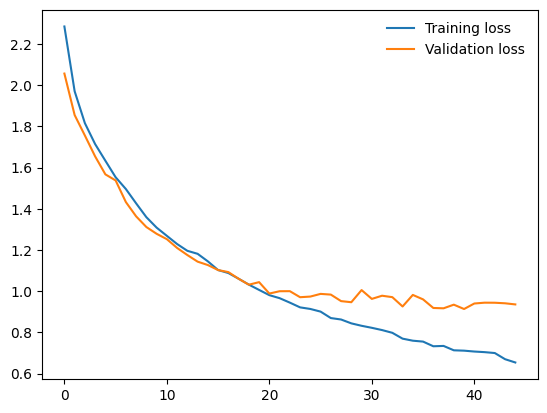

In [27]:
step = 0

#Training loop
train_losses = []
val_losses = []
patience = 5
best_loss = float('inf')
patience_counter = 0
best_val_loss = float('inf')
best_model_wts = None

for epoch in range(train_config['epochs']):
    try:
        if epoch == 26:
            save_weights_path = (
                "../../drive/MyDrive/MVA/".join(["intermediate_model", "epoch", str(epoch)]) + ".pth"
            )
            save_opt_path = (
                "../../drive/MyDrive/MVA/".join(["intermediate_optimizer", "epoch", str(epoch)]) + ".pth"
            )
            torch.save(model.state_dict(), save_weights_path)
            torch.save(optimizer.state_dict(), save_opt_path)
            print("Saved model and optimizer state at epoch 26.")
            train_losses_path = 'train_losses.csv'
            val_losses_path = 'val_losses.csv'
            with open(train_losses_path, 'w', newline='') as tr_csv_file:
                writer = csv.writer(tr_csv_file)
                writer.writerow(train_losses)
            with open(val_losses_path, 'w', newline='') as val_csv_file:
                writer = csv.writer(val_csv_file)
                writer.writerow(val_losses)

        # Model Training
        model.train()
        step += 1

        pbar = tqdm(train_loader)

        # track performance
        epoch_losses = torch.Tensor()
        metrics = PixelwiseMetrics(data_config['num_classes'])

        for idx, (img, y) in enumerate(pbar):
            # load target
            y = y.to(device)
            # model output
            y_hat = model(img)

            # loss computation
            loss = criterion(y_hat, y)

            # backward step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # get prediction
            _, pred = torch.max(y_hat, dim=1)

            epoch_losses = torch.cat([epoch_losses, loss[None].detach().cpu()])
            metrics.add_batch(y, pred)

            pbar.set_description(f"Epoch:{epoch}, Training Loss:{epoch_losses[-100:].mean():.4}")

        mean_loss = epoch_losses.mean()
        train_losses.append(mean_loss)
        train_stats = {
                "train_loss": mean_loss.item(),
                "train_average_accuracy": metrics.get_average_accuracy(),
                "train_mIoU": metrics.get_mIoU(),
                **{
                    "train_accuracy_" + k: v
                    for k, v in metrics.get_classwise_accuracy().items()
                },
                **{
                    "train_IoU_" + k: v
                    for k, v in metrics.get_IoU().items()
                },
            }
        print(train_stats)

        # Model Validation
        model.eval()
        pbar = tqdm(val_loader)

        # track performance
        epoch_losses = torch.Tensor()
        metrics = PixelwiseMetrics(data_config['num_classes'])

        with torch.no_grad():
            for idx, (img, y) in enumerate(pbar):
                y = y.to(device)
                # model output
                y_hat = model(img)

                # loss computation
                loss = criterion(y_hat, y)

                # get prediction
                _, pred = torch.max(y_hat, dim=1)

                epoch_losses = torch.cat([epoch_losses, loss[None].detach().cpu()])
                metrics.add_batch(y, pred)


                pbar.set_description(f"Validation Loss:{epoch_losses[-100:].mean():.4}")

            mean_loss = epoch_losses.mean()
            val_losses.append(mean_loss)
            val_stats = {
                "validation_loss": mean_loss.item(),
                "validation_average_accuracy": metrics.get_average_accuracy(),
                "validation_mIoU": metrics.get_mIoU(),
                **{
                    "validation_accuracy_" + k: v
                    for k, v in metrics.get_classwise_accuracy().items()
                },
                **{
                "train_IoU_" + k: v
                for k, v in metrics.get_IoU().items()
            },
            }

            print(f"Epoch:{epoch}", val_stats)

            # Save model checkpoint every 2 epochs
            if epoch % 2 == 0:
                if epoch == 0:
                    continue

                save_weights_path = (
                    "checkpoints/" + "-".join(["segmentation", "epoch", str(epoch)]) + ".pth"
                )
                save_opt_path = (
                    "checkpoints/" + "-".join(["optimizer", "epoch", str(epoch)]) + ".pth"
                )
                torch.save(model.state_dict(), save_weights_path)
                torch.save(optimizer.state_dict(), save_opt_path)
            val_loss = val_stats["validation_loss"]
            if val_loss < best_loss:
                best_loss = val_loss
                patience_counter = 0
                best_model = model.state_dict()
                best_epoch = epoch
                print("For now best val loss at epoch: ", epoch)
                # Enregistrez les meilleurs poids ici si désiré
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    torch.save(model.state_dict(), '../../drive/MyDrive/MVA/swin-t_SSL_freeze_3_earlyStopped_'+str(epoch)+'.pth')
                    break
    except Exception as e:
        print(f"An error occurred: {e}")
        print(f"Memory usage: {psutil.virtual_memory()}")
        print(f"GPU usage: {GPUtil.getGPUs()}")

torch.save(best_model, "../../drive/MyDrive/MVA/swin-t_SSL_freeze_3_"+str(best_epoch))
print(f"Best model from validation saved to ../../drive/MyDrive/MVA/swin-t_SSL_freeze_3")
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

You can evaluate the model on one example by creating a model's instance, loading checkpoint's weights of the classifier saved during training, running it, and displaying the results:

In [21]:
def test(model, test_ld):
    model.eval()
    pbar = tqdm(test_ld)

    epoch_losses = torch.Tensor()
    metrics = PixelwiseMetrics(data_config['num_classes'])
    all_preds = []
    all_gts = []
    with torch.no_grad():
        for idx, (img, y) in enumerate(pbar):
            y = y.to(device)
            # model output
            y_hat = model(img)

            # loss computation
            loss = criterion(y_hat, y)

            # get prediction
            _, pred = torch.max(y_hat, dim=1)
            all_gts.append(y.cpu().numpy())
            all_preds.append(pred.cpu().numpy())
            epoch_losses = torch.cat([epoch_losses, loss[None].detach().cpu()])
            metrics.add_batch(y, pred)


            pbar.set_description(f"Validation Loss:{epoch_losses[-100:].mean():.4}")

        mean_loss = epoch_losses.mean()
        test_stats = {
            "test_loss": mean_loss.item(),
            "test_average_accuracy": metrics.get_average_accuracy(),
            "test_mIoU": metrics.get_mIoU(),
            **{
                "test_accuracy_" + k: v
                for k, v in metrics.get_classwise_accuracy().items()
            },
            **{
                "train_IoU_" + k: v
                for k, v in metrics.get_IoU().items()
            },
        }
        print("Test stats:")

        # Loss
        print(f"  Loss: {test_stats['test_loss']:.4f}")

        # Average accuracy and mIoU
        print(f"  Average Accuracy: {test_stats['test_average_accuracy']:.4f}")
        print(f"  Mean IoU: {test_stats['test_mIoU']:.4f}")

        # Accuracy per class
        print("  Accuracy by Class:")
        for i in range(data_config['num_classes']):
            print(f"    Class {i}: {test_stats[f'test_accuracy_pixelclass_{i}']:.4f}")

        # IoU per class
        print("  IoU by Class:")
        for i in range(data_config['num_classes']):
            print(f"    Class {i}: {test_stats[f'train_IoU_class_{i}']:.4f}")
        all_preds = np.concatenate(all_preds)
        all_gts = np.concatenate(all_gts)

        # Calculer la matrice de confusion
        conf_matrix = confusion_matrix(all_gts.flatten(), all_preds.flatten(), labels=np.arange(data_config['num_classes']))
        # Normalisation par lignes
        conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

        sns.set(font_scale=0.8)

        # Tracer la matrice de confusion
        plt.figure(figsize=(10, 10))
        ax = sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=list(dict_classes_13.values()), yticklabels=list(dict_classes_13.values()))
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        #sns.set(font_scale=1.2)
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()
    return

In [ ]:
torch.save(model.state_dict(), '../../drive/MyDrive/MVA/swin-t_SSL_freeze_60epochs.pth')
# torch.save(model.state_dict(), 'checkpoints/segmentation-epoch-28.pth')

Validation Loss:0.9284: 100%|██████████| 33/33 [01:15<00:00,  2.29s/it]


Test stats:
  Loss: 0.9284
  Average Accuracy: 0.5517
  Mean IoU: 0.4360
  Accuracy by Class:
    Class 0: 0.8222
    Class 1: 0.3325
    Class 2: 0.7813
    Class 3: 0.1861
    Class 4: 0.8341
    Class 5: 0.5970
    Class 6: 0.8369
    Class 7: 0.3823
    Class 8: 0.7786
    Class 9: 0.7124
    Class 10: 0.4509
    Class 11: 0.4572
    Class 12: 0.0000
  IoU by Class:
    Class 0: 0.6522
    Class 1: 0.2302
    Class 2: 0.6367
    Class 3: 0.1666
    Class 4: 0.7156
    Class 5: 0.4715
    Class 6: 0.6943
    Class 7: 0.2648
    Class 8: 0.7195
    Class 9: 0.4963
    Class 10: 0.3104
    Class 11: 0.3101
    Class 12: 0.0000


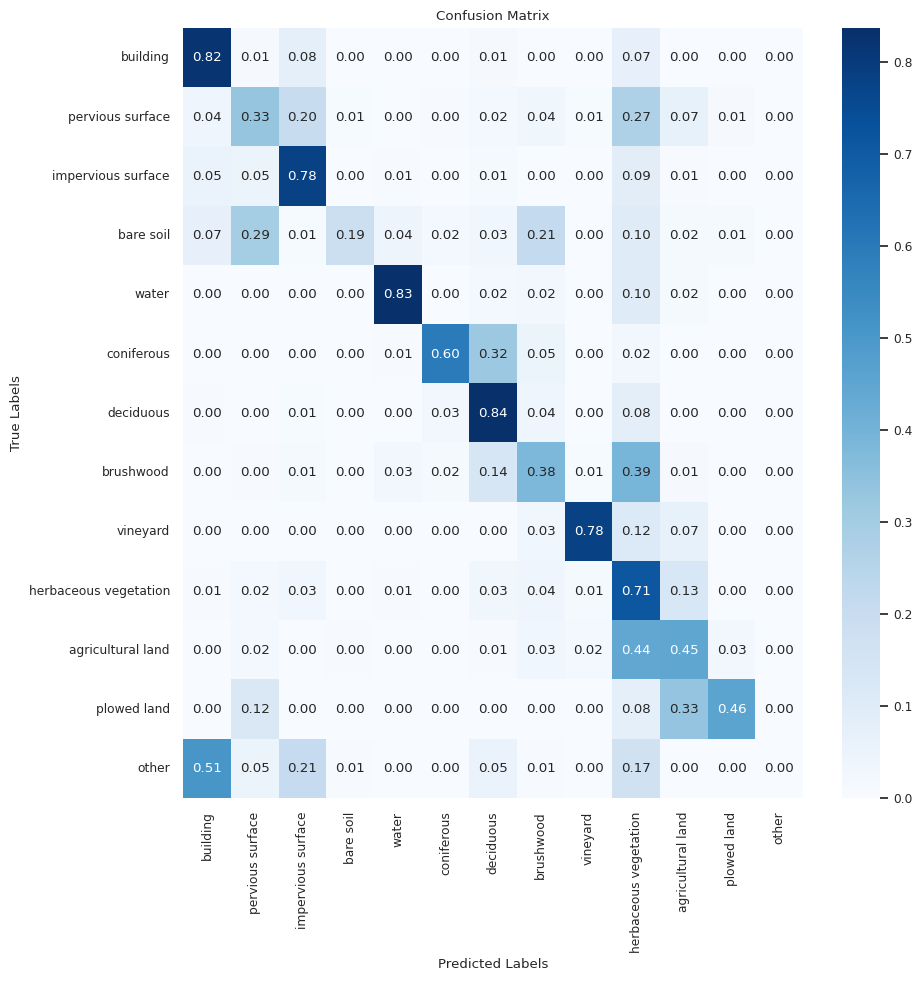

In [22]:
# create a new model's instance
model = DoubleSwinTransformerSegmentation(
        s1_backbone, s2_backbone, out_dim=data_config['num_classes'], device=device)

model = model.to(device)

# load checkpoints weights
model.load_state_dict(torch.load('../../drive/MyDrive/MVA/swin-t_SSL_freeze_3_earlyStopped_45.pth'))#"checkpoints/segmentation-epoch-20.pth"))

test(model, test_loader)